# Set up

In [1]:
import torch
import gpytorch
import pandas as pd
import numpy as np
import tqdm as tqdm

import ast
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import os
import pickle

import math

import arviz as az
import seaborn as sns

import os
import scipy.stats as stats

from statsmodels.graphics.tsaplots import plot_acf
import statsmodels

from scipy.stats import gaussian_kde
from pyro.ops.stats import (
    gelman_rubin,
    split_gelman_rubin,
    autocorrelation,
    effective_sample_size,
    resample,
    quantile,
    weighed_quantile
)

import pickle

import torch.nn.functional as F


import GP_functions.Loss_function as Loss_function
import GP_functions.bound as bound
import GP_functions.Estimation as Estimation
import GP_functions.Training as Training
import GP_functions.Prediction as Prediction
import GP_functions.GP_models as GP_models
import GP_functions.Tools as Tools
import GP_functions.FeatureE as FeatureE

# Data

In [ ]:
# Y_RealCase_train = pd.read_csv('Data/Y_train_std.csv', header=None, delimiter=',')
# df_new = Y_RealCase_train.drop(Y_RealCase_train.columns[-18:], axis=1)
# Y_data_train = df_new.drop(df_new.columns[17], axis=1)

In [ ]:
# np.savetxt("Y_RealCase_train.csv", Y_data_train.values, delimiter=",", fmt="%.8f")

In [2]:
X_train = pd.read_csv('RealCase/RealCase_X_train.csv', header=None, delimiter=',').values
X_test = pd.read_csv('RealCase/RealCase_X_test.csv', header=None, delimiter=',').values

Y_train_pca = pd.read_csv('RealCase/RealCase_Y_train_pca.csv', header=None, delimiter=',').values
Y_test_pca = pd.read_csv('RealCase/RealCase_Y_test_pca.csv', header=None, delimiter=',').values
Realcase_data_pca = pd.read_csv('RealCase/RealCase_Y_pca.csv', header=None, delimiter=',').values

Y_train_std = pd.read_csv('RealCase/RealCase_Y_train_std.csv', header=None, delimiter=',').values
Y_test_std = pd.read_csv('RealCase/RealCase_Y_test_std.csv', header=None, delimiter=',').values
Realcase_data_std = pd.read_csv('RealCase/RealCase_Y_std.csv', header=None, delimiter=',').values

Y_train = pd.read_csv('RealCase/RealCase_Y_train.csv', header=None, delimiter=',').values
Y_test = pd.read_csv('RealCase/RealCase_Y_test.csv', header=None, delimiter=',').values
Realcase_data = pd.read_csv('RealCase/RealCase.csv', header=None, delimiter=',').values

# Realcase_data_extra = pd.read_csv('RealCase/RealCase_Y_extra.csv', header=None, delimiter=',').values

In [ ]:
Y_train.shape

In [ ]:
Realcase_data.shape

In [ ]:
def plot_hist_grid(Y, real, start=0, num=24, ncols=6, bins=30):
    real = np.asarray(real).squeeze()
    if real.ndim == 0:
        real = real[None]

    p = Y.shape[1]
    end = min(p, start + num)
    idxs = list(range(start, end))

    nrows = math.ceil(len(idxs) / ncols)
    fig, axes = plt.subplots(nrows, ncols, figsize=(3.2*ncols, 2.4*nrows), squeeze=False)

    for k, j in enumerate(idxs):
        r, c = divmod(k, ncols)
        ax = axes[r][c]
        ax.hist(Y[:, j], bins=bins)
        ax.axvline(real[j])  # RealCase 的位置
        ax.set_title(f"col {j}")
        ax.grid(alpha=0.2)

    # 多余子图关掉
    for k in range(len(idxs), nrows*ncols):
        r, c = divmod(k, ncols)
        axes[r][c].axis("off")

    plt.tight_layout()
    plt.show()

real = Realcase_data.squeeze()
plot_hist_grid(Y_train, real, start=0,  num=33)




In [ ]:
mask = Y_train[:,0] < 181

In [ ]:
X_train[mask,:]

In [ ]:
def plot_hist_grid(Y, start=0, num=24, ncols=6, bins=30):


    p = Y.shape[1]
    end = min(p, start + num)
    idxs = list(range(start, end))

    nrows = math.ceil(len(idxs) / ncols)
    fig, axes = plt.subplots(nrows, ncols, figsize=(3.2*ncols, 2.4*nrows), squeeze=False)

    for k, j in enumerate(idxs):
        r, c = divmod(k, ncols)
        ax = axes[r][c]
        ax.hist(Y[:, j], bins=bins)
        ax.set_title(f"col {j}")
        ax.grid(alpha=0.2)

    # 多余子图关掉
    for k in range(len(idxs), nrows*ncols):
        r, c = divmod(k, ncols)
        axes[r][c].axis("off")

    plt.tight_layout()
    plt.show()

# real = Realcase_data.squeeze()
plot_hist_grid(Y_train_std, start=0,  num=33)




In [ ]:
import seaborn
seaborn.pairplot(pd.DataFrame(np.column_stack((Y_train[:,[1,2,7,8]], X_train[:,:10]))))

# outer - zone 4 causes zone 1
# outer - zone 1 causes zone 2
# outer - zone 3 causes zone 3
# outer - zone 2 causes zone 4
# inner - zone 4 causes zone 1
# middle - zone 5 causes zone 5
# middle - zone 1 causes zone 2
# middle - zone 3 causes zone 3
# middle - zone 2 causes zone 4
# seaborn.kdeplot(pd.DataFrame(Y_train[:,[7,8,9,10,11,12]]))

In [ ]:
np.column_stack((Y_train[:,2], X_train[:,7:9]))

In [ ]:
X_train[:,0:2]

## tensor

In [3]:
train_x = torch.tensor(X_train, dtype=torch.float32)
test_x = torch.tensor(X_test, dtype=torch.float32)

train_y_pca = torch.tensor(Y_train_pca, dtype=torch.float32)
test_y_pca = torch.tensor(Y_test_pca, dtype=torch.float32)
realcase_y_pca = torch.tensor(Realcase_data_pca, dtype=torch.float32)

train_y = torch.tensor(Y_train_std, dtype=torch.float32)
test_y = torch.tensor(Y_test_std, dtype=torch.float32)
realcase_y = torch.tensor(Realcase_data_std, dtype=torch.float32)


In [ ]:
col_min = np.nanmin(Y_train_pca, axis=0)
col_max = np.nanmax(Y_train_pca, axis=0)


((Realcase_data_pca >= col_min) & (Realcase_data_pca <= col_max)).sum(axis=1)

In [ ]:
Y_train_pca.shape

In [ ]:
(Realcase_data >= col_min) & (Realcase_data <= col_max)

In [ ]:
col_min

In [ ]:
col_max

In [ ]:
Realcase_data

In [ ]:
Realcase_data_pca

In [ ]:
def plot_hist_grid(Y, real, start=0, num=24, ncols=6, bins=30):
    real = np.asarray(real).squeeze()
    if real.ndim == 0:
        real = real[None]

    p = Y.shape[1]
    end = min(p, start + num)
    idxs = list(range(start, end))

    nrows = math.ceil(len(idxs) / ncols)
    fig, axes = plt.subplots(nrows, ncols, figsize=(3.2*ncols, 2.4*nrows), squeeze=False)

    for k, j in enumerate(idxs):
        r, c = divmod(k, ncols)
        ax = axes[r][c]
        ax.hist(Y[:, j], bins=bins)
        ax.axvline(real[j])  # RealCase 的位置
        ax.set_title(f"col {j}")
        ax.grid(alpha=0.2)

    # 多余子图关掉
    for k in range(len(idxs), nrows*ncols):
        r, c = divmod(k, ncols)
        axes[r][c].axis("off")

    plt.tight_layout()
    plt.show()

real = Realcase_data.squeeze()
plot_hist_grid(Y_train, real, start=0,  num=33)




# Emulator

In [4]:
# Device = 'cpu'

Device = 'cuda'

In [ ]:
MVGP_models, MVGP_likelihoods = Training.train_MultitaskVGP_minibatch(
    train_x=train_x.to(Device),
    train_y=train_y_pca.to(Device),
    covar_type='RQ',
    num_latents=24,
    num_inducing=500,
    lr_hyper=0.01,
    lr_variational=0.1,
    num_iterations=20000,
    patience=10,
    device=Device,
    batch_size=512,
    eval_every=100,
    eval_batch_size=1024
)

In [ ]:
checkpoint = {
    'model_state_dict': MVGP_models.state_dict(),
    'likelihood_state_dict': MVGP_likelihoods.state_dict(),
    'model_params': {
        'num_latents': 24,
        'num_inducing': 500,
        'covar_type': 'RQ',
        'input_dim': train_x.size(1),
        'num_tasks': train_y.size(1)
    }
}

torch.save(checkpoint, 'multitask_gp_checkpoint_Realcase_pca.pth')

In [5]:
checkpoint = torch.load('multitask_gp_checkpoint_Realcase.pth', map_location=Device)
model_params = checkpoint['model_params']

MVGP_models = GP_models.MultitaskVariationalGP(train_x, train_y, 
                                               num_latents=model_params['num_latents'],
                                               num_inducing=model_params['num_inducing'],  
                                               covar_type=model_params['covar_type']).to(Device)

MVGP_models.load_state_dict(checkpoint['model_state_dict'])

MVGP_likelihoods = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=train_y.shape[1]).to(Device)
MVGP_likelihoods.load_state_dict(checkpoint['likelihood_state_dict'])

MVGP_models.eval()
MVGP_likelihoods.eval()

MultitaskGaussianLikelihood(
  (raw_task_noises_constraint): GreaterThan(1.000E-04)
  (raw_noise_constraint): GreaterThan(1.000E-04)
)

In [ ]:
Prediction.preds_for_one_model(MVGP_models, MVGP_likelihoods, test_x.cuda().unsqueeze(0)).reshape(512, 33)

In [ ]:
test_y

In [ ]:
torch.mean((Prediction.preds_for_one_model(MVGP_models, MVGP_likelihoods, test_x.cuda().unsqueeze(0)).reshape(512, 33) - test_y.cuda()) ** 2)

In [ ]:
def r2_torch(y_true: torch.Tensor, y_pred: torch.Tensor, eps: float = 1e-12) -> torch.Tensor:
    """
    返回标量 R^2（对所有元素整体计算）。
    R^2 = 1 - SSE/SST, 其中 SST = sum((y - mean(y))^2)
    若 SST ~ 0（y_true 常数），则返回 0（也可按需改为 1 或 nan）。
    """
    y_true = y_true.to(dtype=torch.float32)
    y_pred = y_pred.to(dtype=torch.float32)

    y = y_true.reshape(-1)
    yhat = y_pred.reshape(-1)

    sse = torch.sum((yhat - y) ** 2)
    sst = torch.sum((y - torch.mean(y)) ** 2)

    denom = torch.clamp(sst, min=eps)
    r2 = 1.0 - sse / denom

    # 若 sst 非常小（y_true 常数），上式会变成 1 - sse/eps，通常不符合直觉
    # 这里将其定义为 0（你可以按习惯改成 1 或 torch.nan）
    r2 = torch.where(sst < eps, torch.zeros_like(r2), r2)
    return r2

r2_torch(Prediction.preds_for_one_model(MVGP_models, MVGP_likelihoods, test_x.cuda().unsqueeze(0)).reshape(512, 33) , test_y.cuda())

## MVGP

In [ ]:
checkpoint = torch.load('multitask_gp_checkpoint_Realcase.pth', map_location=Device)
model_params = checkpoint['model_params']

MVGP_models = GP_models.MultitaskVariationalGP(train_x, train_y, 
                                               num_latents=model_params['num_latents'],
                                               num_inducing=model_params['num_inducing'],  
                                               covar_type=model_params['covar_type']).to(Device)

MVGP_models.load_state_dict(checkpoint['model_state_dict'])

MVGP_likelihoods = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=train_y.shape[1]).to(Device)
MVGP_likelihoods.load_state_dict(checkpoint['likelihood_state_dict'])

MVGP_models.eval()
MVGP_likelihoods.eval()


## L.DKMGP

In [ ]:
row_idx = 0

input_point = realcase_y

local_train_x, local_train_y = Tools.find_k_nearest_neighbors_GPU(input_point, train_x, train_y, k=500)

bounds = bound.get_bounds(local_train_x)

MultitaskGP_models, MultitaskGP_likelihoods = Training.train_one_row_NNMultitaskGP(
    local_train_x, local_train_y, n_tasks = local_train_y.shape[1], 
    feature_extractor_class = FeatureE.FeatureExtractor_1, covar_type = 'RBF', 
    lr=0.05, num_iterations=5000, patience=10, device = Device, show_progress=True)

# PE

In [10]:
row_idx = 5

# input_point = realcase_y[row_idx]

# local_train_x, local_train_y = Tools.find_k_nearest_neighbors_GPU(input_point, train_x, train_y, k=500)

bounds = bound.get_bounds(train_x)

In [ ]:
bound.get_bounds(train_x)

In [ ]:
input_point

In [ ]:
local_train_y[0:10]

In [ ]:
local_train_x[0:10]

In [ ]:
bounds

In [ ]:
import math

def plot_hist_grid(Y, real, start=0, num=24, ncols=6, bins=30):
    real = np.asarray(real).squeeze()
    if real.ndim == 0:
        real = real[None]

    p = Y.shape[1]
    end = min(p, start + num)
    idxs = list(range(start, end))

    nrows = math.ceil(len(idxs) / ncols)
    fig, axes = plt.subplots(nrows, ncols, figsize=(3.2*ncols, 2.4*nrows), squeeze=False)

    for k, j in enumerate(idxs):
        r, c = divmod(k, ncols)
        ax = axes[r][c]
        ax.hist(Y[:, j], bins=bins)
        ax.axvline(real[j])  # RealCase 的位置
        ax.set_title(f"col {j}")
        ax.grid(alpha=0.2)

    # 多余子图关掉
    for k in range(len(idxs), nrows*ncols):
        r, c = divmod(k, ncols)
        axes[r][c].axis("off")

    plt.tight_layout()
    plt.show()


plot_hist_grid(local_train_y, realcase_y_pca, start=0,  num=33)




In [ ]:
local_train_x

In [ ]:
Y = local_train_x
start=0
num=11
ncols=6
bins=30

p = Y.shape[1]
end = min(p, start + num)
idxs = list(range(start, end))

nrows = math.ceil(len(idxs) / ncols)
fig, axes = plt.subplots(nrows, ncols, figsize=(3.2*ncols, 2.4*nrows), squeeze=False)

for k, j in enumerate(idxs):
    r, c = divmod(k, ncols)
    ax = axes[r][c]
    ax.hist(Y[:, j], bins=bins)
    ax.set_title(f"col {j}")
    ax.grid(alpha=0.2)

# 多余子图关掉
for k in range(len(idxs), nrows*ncols):
    r, c = divmod(k, ncols)
    axes[r][c].axis("off")

plt.tight_layout()
plt.show()

In [ ]:

from scipy.stats import qmc

def sobol_loguniform(
    d: int,
    *,
    m: int | None = None,
    n: int | None = None,
    l_bounds=0.1,
    u_bounds=5.0,
    seed: int | None = None,
    scramble: bool = True,
    log_base: float = np.e,   # np.e 表示自然对数；10 表示 log10
    return_engine: bool = False
):
    """
    生成 Sobol 序列并将其映射为对数均匀分布（log-uniform）采样。

    参数
    ----
    d : int
        维度。
    m : int, optional
        使用 random_base2(m) 生成 2**m 个 Sobol 点（推荐 Sobol 的标准用法）。
    n : int, optional
        使用 random(n) 生成 n 个 Sobol 点（不要求 2 的幂）。
    l_bounds, u_bounds : float or array-like
        每一维的下界/上界。可传标量或长度为 d 的列表/数组。
        注意：log-uniform 要求 l_bounds > 0。
    seed : int, optional
        随机种子（scramble=True 时生效）。
    scramble : bool
        是否打乱（推荐 True）。
    log_base : float
        对数底。np.e 表示自然对数；10 表示 log10。
    return_engine : bool
        是否同时返回 Sobol engine。

    返回
    ----
    X : ndarray, shape (N, d)
        对数均匀采样点。
    (optional) engine : qmc.Sobol
    """
    if (m is None) == (n is None):
        raise ValueError("请二选一：提供 m（生成 2**m 个点）或提供 n（生成 n 个点）。")

    lb = np.asarray(l_bounds, dtype=float)
    ub = np.asarray(u_bounds, dtype=float)

    if lb.ndim == 0:
        lb = np.full(d, lb)
    if ub.ndim == 0:
        ub = np.full(d, ub)

    if lb.shape != (d,) or ub.shape != (d,):
        raise ValueError(f"l_bounds/u_bounds 必须是标量或长度为 d={d} 的数组。")
    if np.any(lb <= 0):
        raise ValueError("log-uniform 要求所有下界 l_bounds > 0。")
    if np.any(ub <= lb):
        raise ValueError("要求 u_bounds > l_bounds。")

    engine = qmc.Sobol(d=d, scramble=scramble, seed=seed)

    U = engine.random_base2(m=m) if m is not None else engine.random(n=n)

    # log-uniform 逐维变换
    if log_base == 10:
        log_lb = np.log10(lb)
        log_ub = np.log10(ub)
        X = 10 ** (log_lb + U * (log_ub - log_lb))
    elif log_base == np.e:
        log_lb = np.log(lb)
        log_ub = np.log(ub)
        X = np.exp(log_lb + U * (log_ub - log_lb))
    else:
        # 任意底：log_b(x)=ln(x)/ln(b)
        ln_lb, ln_ub = np.log(lb), np.log(ub)
        X = np.exp(ln_lb + U * (ln_ub - ln_lb))  # 采样不依赖底，只影响“解释”
    
    return (X, engine) if return_engine else X

In [ ]:
X_extra = sobol_loguniform(
    d=10,
    m=10,
    l_bounds=[0.1]*10,
    u_bounds=[5]*10,
    seed=24,
    scramble=True,
    log_base=np.e
)

In [ ]:
X_extra

In [ ]:
df = X_extra
m, n = df.shape


new_data = np.zeros((m, 34))


mapping = {
    0: [4, 16],
    1: [5, 17],
    2: [10, 22],
    3: [11, 23],
    4: [8, 6, 20, 18],
    5: [9, 7, 21, 19],
    6: [2, 0, 14, 12],
    7: [3, 1, 15, 13],
    8: [24, 26, 28, 30, 32],
    9: [25, 27, 29, 31, 33]
}

for orig_col, new_cols in mapping.items():
    for new_col in new_cols:
        new_data[:, new_col] = df[:, orig_col]

In [ ]:
new_data.shape

In [ ]:
np.savetxt("X_extra_RealCase.txt", new_data, fmt='%0.4f')

In [ ]:
Y = X_extra
start=0
num=11
ncols=6
bins=30

p = Y.shape[1]
end = min(p, start + num)
idxs = list(range(start, end))

nrows = math.ceil(len(idxs) / ncols)
fig, axes = plt.subplots(nrows, ncols, figsize=(3.2*ncols, 2.4*nrows), squeeze=False)

for k, j in enumerate(idxs):
    r, c = divmod(k, ncols)
    ax = axes[r][c]
    ax.hist(Y[:, j], bins=bins)
    ax.set_title(f"col {j}")
    ax.grid(alpha=0.2)

# 多余子图关掉
for k in range(len(idxs), nrows*ncols):
    r, c = divmod(k, ncols)
    axes[r][c].axis("off")

plt.tight_layout()
plt.show()

# PE Run

In [6]:
row_idx = 5

In [47]:
estimated_params_tmp, Loss_tmp = Estimation.multi_start_estimation(
        MVGP_models, MVGP_likelihoods, row_idx, realcase_y, bounds,
        Estimation.estimate_params_for_one_model_Adam, num_starts=8, num_iterations=3000, lr=0.1,
        patience=15, attraction_threshold=0.1, repulsion_strength=0.1, device=Device, show_progress=True
    )


Multi-start:   0%|          | 0/8 [00:00<?, ?it/s]

Start 1/8:   0%|          | 0/3000 [00:00<?, ?it/s]

Start 2/8:   0%|          | 0/3000 [00:00<?, ?it/s]

Start 3/8:   0%|          | 0/3000 [00:00<?, ?it/s]

Start 4/8:   0%|          | 0/3000 [00:00<?, ?it/s]

Start 5/8:   0%|          | 0/3000 [00:00<?, ?it/s]

Start 6/8:   0%|          | 0/3000 [00:00<?, ?it/s]

Start 7/8:   0%|          | 0/3000 [00:00<?, ?it/s]

Start 8/8:   0%|          | 0/3000 [00:00<?, ?it/s]

In [48]:
estimated_params_tmp

array([2.0319333, 0.1003   , 2.4934661, 2.485779 , 0.8774323, 0.6448459,
       1.5071881, 0.1003   , 1.0500828, 1.740363 ], dtype=float32)

In [ ]:
Loss_tmp

In [ ]:
torch.tensor(estimated_params_tmp)

In [49]:
Prediction.preds_for_one_model(MVGP_models, MVGP_likelihoods, torch.tensor(estimated_params_tmp).cuda().unsqueeze(0))

tensor([ 0.7364, -1.3666, -1.3427, -1.1964, -1.2561, -1.1449,  0.2893, -1.4868,
        -1.4044, -0.7554, -1.1627, -1.2043,  0.5628, -0.8938, -0.5025, -0.6644,
        -0.1343,  1.0094,  0.9361,  1.0902,  1.1427,  0.6907, -0.2134,  1.1881,
         1.1376,  0.8469,  1.1129,  1.0707, -0.2592,  0.5320,  0.3254,  0.5240,
         0.4133], device='cuda:0', grad_fn=<ViewBackward0>)

In [50]:
realcase_y[row_idx]

tensor([ 0.8210, -1.1686, -1.2190, -0.9707, -1.1715, -1.0731,  0.2331, -1.3599,
        -1.2211, -0.7425, -0.9878, -1.1823,  0.7720, -1.0078,  0.3239, -0.8874,
        -0.0431,  1.1068,  1.2265,  1.2614,  1.1731,  0.9680, -0.0702,  1.2403,
         0.9804,  1.0355,  1.1740,  1.0124, -0.1998,  0.7370,  0.5431,  0.5481,
         0.4634])

In [ ]:
torch.mean((Prediction.preds_for_one_model(MVGP_models, MVGP_likelihoods, torch.tensor(estimated_params_tmp).cuda().unsqueeze(0)) - realcase_y[row_idx].cuda()) ** 2)

# Weighted L2

In [9]:
import torch
from typing import Sequence, Tuple, Union, Optional
from tqdm import tqdm


TensorLike = Union[torch.Tensor, Sequence[float]]



def estimate_params_for_one_model_Adam_weightedL2(
    model,
    likelihood,
    row_idx: int,
    test_y: torch.Tensor,
    initial_guess: TensorLike,
    param_ranges: Sequence[Tuple[float, float]],
    weights: TensorLike,
    num_iterations: int = 1000,
    lr: float = 0.05,
    patience: int = 50,
    attraction_threshold: float = 0.1,
    repulsion_strength: float = 0.5,
    device: str = "cpu",
    show_progress: bool = False,
    progress_desc: str = "WeightedL2-Adam",
) -> Tuple[torch.Tensor, float]:

    target_y = test_y[row_idx].to(device)
    target_x = torch.tensor(initial_guess, dtype=torch.float32).to(device).unsqueeze(0).requires_grad_(True)

    optimizer = torch.optim.Adam([target_x], lr=lr)

    model.eval()
    likelihood.eval()

    best_loss = float("inf")
    best_state = target_x.detach().clone()
    bad_count = 0


    w = torch.as_tensor(weights).reshape(-1).to(device)
    iterator = tqdm(range(num_iterations), disable=not show_progress, desc=progress_desc, leave=False)


    for i in iterator:
        optimizer.zero_grad(set_to_none=True)
        loss = torch.sqrt(torch.sum(w * ((likelihood(model(target_x)).mean - target_y) ** 2)))
        loss.backward(retain_graph=True)


        grad_norm = float(target_x.grad.data.norm(2).item())
        if grad_norm < attraction_threshold:
            target_x.grad.data.add_(repulsion_strength * torch.randn_like(target_x.grad.data))

        optimizer.step()

        with torch.no_grad():
            for j, (lo, hi) in enumerate(param_ranges):
                target_x[0, j].clamp_(lo, hi)

        loss_val = float(loss.item())

        if loss_val < best_loss:
            best_loss = loss_val
            best_state = target_x.detach().clone()
            bad_count = 0
        else:
            bad_count += 1
            if bad_count >= patience:
                if show_progress:
                    iterator.set_postfix(loss=f"{loss_val:.4g}", best=f"{best_loss:.4g}", early_stop=f"iter {i}")
                break

        if show_progress:
            iterator.set_postfix(loss=f"{loss_val:.4g}", best=f"{best_loss:.4g}", bad=bad_count, grad=f"{grad_norm:.3g}")



    return best_state.squeeze(0), best_loss




In [10]:
row_idx = 5
D = realcase_y[row_idx].numel()
weights = torch.ones(D)
weights[0] = 66.0
# weights[1:13] = 2.0

In [11]:
x_hat, best_loss = estimate_params_for_one_model_Adam_weightedL2(
    model=MVGP_models,
    likelihood=MVGP_likelihoods,
    row_idx=row_idx,
    test_y=realcase_y,
    initial_guess=[0.1006    , 3.5075033 , 2.8576572 , 3.1968546 , 0.64672416, 1.100336  , 0.8331495 , 0.8760642 , 2.2035856 , 0.65233546],
    param_ranges=bounds,
    weights=weights,
    num_iterations=2000,
    lr=0.03,
    patience=100,
    device=Device,
    show_progress=True,
    progress_desc="WeightedL2-Adam",
)


In [12]:
x_hat

tensor([0.1088, 2.6896, 2.1084, 2.9760, 0.8393, 0.7129, 1.4761, 0.1003, 2.6613,
        0.1569], device='cuda:0')

In [13]:
Prediction.preds_for_one_model(MVGP_models, MVGP_likelihoods, (x_hat).cuda().unsqueeze(0))

tensor([ 8.0779e-01, -1.4133e+00, -1.4182e+00, -1.1195e+00, -1.2999e+00,
        -1.1334e+00,  2.9251e-01, -1.5263e+00, -1.4399e+00, -8.9482e-01,
        -1.3295e+00, -1.2383e+00,  5.3219e-01, -7.5985e-01, -7.4914e-01,
        -8.5103e-01,  7.6289e-04,  1.1020e+00,  1.0473e+00,  1.1310e+00,
         1.0827e+00,  6.7246e-01, -2.2470e-01,  1.2180e+00,  1.0384e+00,
         9.4302e-01,  1.2952e+00,  1.0460e+00, -3.0379e-01,  3.3723e-01,
         6.0606e-01,  7.3109e-01,  2.7527e-01], device='cuda:0',
       grad_fn=<ViewBackward0>)

In [14]:
realcase_y[row_idx]

tensor([ 0.8210, -1.1686, -1.2190, -0.9707, -1.1715, -1.0731,  0.2331, -1.3599,
        -1.2211, -0.7425, -0.9878, -1.1823,  0.7720, -1.0078,  0.3239, -0.8874,
        -0.0431,  1.1068,  1.2265,  1.2614,  1.1731,  0.9680, -0.0702,  1.2403,
         0.9804,  1.0355,  1.1740,  1.0124, -0.1998,  0.7370,  0.5431,  0.5481,
         0.4634])

In [ ]:
realcase_y[0]

# Check result

In [ ]:
MVGP_pca_result = pd.read_csv('RealCase/Result/MVGP_21_result.csv')
MVGP_pca_result['estimated_params_list'] = MVGP_pca_result['estimated_params'].apply(ast.literal_eval)

MVGP_pca_result = np.array(MVGP_pca_result['estimated_params_list'].tolist())

In [ ]:
MVGP_pca_result

In [ ]:
realcase_paras_pca = torch.tensor(MVGP_pca_result, dtype=torch.float32)

In [ ]:
preds_tmp = Prediction.preds_for_one_model(
        MVGP_models, MVGP_likelihoods, realcase_paras_pca.to(Device)
        ).cpu().detach().numpy()

# MCMC

In [56]:
mcmc_result_Uniform = Estimation.run_mcmc_Uniform(
    Prediction.preds_distribution, MVGP_models, MVGP_likelihoods, 
    row_idx, realcase_y, bounds, 
    num_sampling=1200, warmup_step=300, num_chains=1, device=Device
)
posterior_samples_Uniform = mcmc_result_Uniform.get_samples()

Sample: 100%|██████████| 1500/1500 [15:09,  1.65it/s, step size=1.06e-01, acc. prob=0.938]


In [57]:
torch.save(posterior_samples_Uniform, "mcmc_RealCase_test_idx_5.pt")

## Weighted mcmc

In [58]:
import torch
import pyro
import pyro.distributions as dist
from pyro.infer.mcmc import NUTS, MCMC


def run_mcmc_Uniform_weighted_diag(
    Pre_function,
    Models,
    Likelihoods,
    row_idx,
    test_y,
    bounds,
    num_sampling=2000,
    warmup_step=1000,
    num_chains=1,
    device="cpu",
    weights=None,               # (D,) positive; larger => more important
    normalize_weights=True,     # keep mean(weights)=1 for stable scale
    min_var=1e-12,              # numerical stability for variance
):
    """
    Assumptions:
      - Pre_function(...) returns preds = likelihood(model(xxx)), i.e. predictive distribution over y,
        so preds.variance already includes observation noise from the likelihood.
      - test_y[row_idx, :] is the observed 33-D vector.
    Weighted diagonal likelihood:
      y_j | theta ~ Normal(mu_j(theta), sqrt(var_j(theta) / w_j))
    """

    # -----------------------
    # Helpers
    # -----------------------
    def _to_1d(x: torch.Tensor) -> torch.Tensor:
        # squeeze singleton dims and flatten; expect a vector ultimately
        x = x.squeeze()
        if x.dim() != 1:
            x = x.reshape(-1)
        return x

    # -----------------------
    # Prepare data / bounds
    # -----------------------
    test_y = test_y.to(dtype=torch.float32, device=device)
    y_obs = _to_1d(test_y[row_idx, :])  # (D,)
    D = y_obs.numel()

    bounds_t = []
    for b in bounds:
        lo = torch.tensor(b[0], dtype=torch.float32, device=device)
        hi = torch.tensor(b[1], dtype=torch.float32, device=device)
        bounds_t.append((lo, hi))

    # -----------------------
    # Prepare weights
    # -----------------------
    if weights is None:
        w = torch.ones(D, dtype=torch.float32, device=device)
    else:
        w = torch.as_tensor(weights, dtype=torch.float32, device=device)
        w = _to_1d(w)
        if w.numel() != D:
            raise ValueError(f"weights length mismatch: got {w.numel()} but expected {D}")
        if torch.any(w <= 0):
            raise ValueError("All weights must be > 0.")
    if normalize_weights:
        w = w / w.mean()

    # -----------------------
    # Pyro model for NUTS
    # -----------------------
    def model():
        params = []
        for i, (min_val, max_val) in enumerate(bounds_t):
            param_i = pyro.sample(f"param_{i}", dist.Uniform(min_val, max_val))
            params.append(param_i)

        theta = torch.stack(params)  # (P,)

        # predictive distribution over y (already includes observation noise)
        gp_pred = Pre_function(Models, Likelihoods, theta.unsqueeze(0))

        mu = _to_1d(gp_pred.mean).to(device=device, dtype=torch.float32)       # (D,)
        var = _to_1d(gp_pred.variance).to(device=device, dtype=torch.float32) # (D,)

        if mu.numel() != D or var.numel() != D:
            raise RuntimeError(
                f"Predictive shape mismatch: mu has {mu.numel()} elems, var has {var.numel()} elems, expected {D}."
            )

        # weighted diagonal: var_j -> var_j / w_j
        var_w = torch.clamp(var / w, min=min_var)
        sigma_w = torch.sqrt(var_w)

        pyro.sample("obs", dist.Normal(mu, sigma_w).to_event(1), obs=y_obs)

    # -----------------------
    # Run NUTS
    # -----------------------
    nuts_kernel = NUTS(model)
    mcmc = MCMC(
        nuts_kernel,
        num_samples=num_sampling,
        warmup_steps=warmup_step,
        num_chains=num_chains,
    )
    mcmc.run()
    return mcmc




In [8]:
weights = torch.ones(33)
weights[0] = 66.0

In [60]:
mcmc = run_mcmc_Uniform_weighted_diag(
    Pre_function=Prediction.preds_distribution,
    Models=MVGP_models,
    Likelihoods=MVGP_likelihoods,
    row_idx=row_idx,
    test_y=realcase_y,
    bounds=bounds,
    num_sampling=2400,
    warmup_step=600,
    weights=weights,
    device="cuda",
)
samples = mcmc.get_samples()

Sample: 100%|██████████| 3000/3000 [09:47,  5.11it/s, step size=2.93e-01, acc. prob=0.897]


In [61]:
torch.save(samples, "mcmc_RealCase_test_0126_idx_5.pt")

## Random-Walk Metropolis mcmc

In [ ]:
import torch
import pyro
import pyro.distributions as dist
from pyro.infer.mcmc import MCMC
from pyro.infer.mcmc import RandomWalkKernel  # <- MH / RWMH


def run_mcmc_Uniform_weighted_diag_MH(
    Pre_function,
    Models,
    Likelihoods,
    row_idx,
    test_y,
    bounds,
    num_sampling=2000,
    warmup_step=1000,
    num_chains=1,
    device="cpu",
    weights=None,               # (D,) positive; larger => more important
    normalize_weights=True,     # keep mean(weights)=1 for stable scale
    min_var=1e-12,              # numerical stability for variance
    init_step_size=0.1,         # MH random-walk step size (in unconstrained space)
    target_accept_prob=0.234,   # typical RWM target acceptance
):


    # -----------------------
    # Helpers
    # -----------------------
    def _to_1d(x: torch.Tensor) -> torch.Tensor:
        x = x.squeeze()
        if x.dim() != 1:
            x = x.reshape(-1)
        return x

    def _set_eval(obj):
        # allow Models / Likelihoods to be a single module or a list/tuple
        if isinstance(obj, (list, tuple)):
            for m in obj:
                if hasattr(m, "eval"):
                    m.eval()
        else:
            if hasattr(obj, "eval"):
                obj.eval()

    # -----------------------
    # Prepare data / bounds
    # -----------------------
    test_y = test_y.to(dtype=torch.float32, device=device)
    y_obs = _to_1d(test_y[row_idx, :])  # (D,)
    D = y_obs.numel()

    bounds_t = []
    for b in bounds:
        lo = torch.tensor(b[0], dtype=torch.float32, device=device)
        hi = torch.tensor(b[1], dtype=torch.float32, device=device)
        bounds_t.append((lo, hi))

    # -----------------------
    # Prepare weights
    # -----------------------
    if weights is None:
        w = torch.ones(D, dtype=torch.float32, device=device)
    else:
        w = torch.as_tensor(weights, dtype=torch.float32, device=device)
        w = _to_1d(w)
        if w.numel() != D:
            raise ValueError(f"weights length mismatch: got {w.numel()} but expected {D}")
        if torch.any(w <= 0):
            raise ValueError("All weights must be > 0.")
    if normalize_weights:
        w = w / w.mean()

    # -----------------------
    # Pyro model
    # -----------------------
    def model():
        params = []
        for i, (min_val, max_val) in enumerate(bounds_t):
            param_i = pyro.sample(f"param_{i}", dist.Uniform(min_val, max_val))
            params.append(param_i)

        theta = torch.stack(params)  # (P,)

        # ensure GP parts are in eval mode
        _set_eval(Models)
        _set_eval(Likelihoods)

        # predictive distribution over y (already includes observation noise)
        gp_pred = Pre_function(Models, Likelihoods, theta.unsqueeze(0))

        mu = _to_1d(gp_pred.mean).to(device=device, dtype=torch.float32)        # (D,)
        var = _to_1d(gp_pred.variance).to(device=device, dtype=torch.float32)  # (D,)

        if mu.numel() != D or var.numel() != D:
            raise RuntimeError(
                f"Predictive shape mismatch: mu has {mu.numel()} elems, var has {var.numel()} elems, expected {D}."
            )

        # weighted diagonal: var_j -> var_j / w_j
        var_w = torch.clamp(var / w, min=min_var)
        sigma_w = torch.sqrt(var_w)

        pyro.sample("obs", dist.Normal(mu, sigma_w).to_event(1), obs=y_obs)

    # -----------------------
    # Run MH (Random-Walk Metropolis)
    # -----------------------
    mh_kernel = RandomWalkKernel(
        model,
        init_step_size=float(init_step_size),
        target_accept_prob=float(target_accept_prob),
    )

    mcmc = MCMC(
        mh_kernel,
        num_samples=num_sampling,
        warmup_steps=warmup_step,
        num_chains=num_chains,
    )
    mcmc.run()
    return mcmc


In [24]:
mcmc = run_mcmc_Uniform_weighted_diag_MH(
    Pre_function=Prediction.preds_distribution,
    Models=MVGP_models,
    Likelihoods=MVGP_likelihoods,
    row_idx=row_idx,
    test_y=realcase_y,
    bounds=bounds,
    num_sampling=4000,
    warmup_step=2000,
    num_chains=4,
    device="cuda",
    weights=weights,  # or None
    init_step_size=0.15,
    target_accept_prob=0.234,
)

samples = mcmc.get_samples()

Warmup [1]:   0%|          | 0/6000 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/6000 [00:00, ?it/s]

Warmup [3]:   0%|          | 0/6000 [00:00, ?it/s]

Warmup [4]:   0%|          | 0/6000 [00:00, ?it/s]

AttributeError: Can't get local object 'run_mcmc_Uniform_weighted_diag_MH.<locals>.model'

## RandomWalk mcmc with noise

In [8]:
import torch
import pyro
import pyro.distributions as dist
from pyro.infer.mcmc import MCMC
from pyro.infer.mcmc.rwkernel import RandomWalkKernel

def run_mcmc_Uniform_MH_noise(
    Pre_function, Models, Likelihoods, row_idx, test_y, bounds,
    num_sampling=2000, warmup_step=1000, num_chains=1, device="cpu",
    # --- MH kernel ---
    init_step_size=0.1,
    target_accept_prob=0.234,
    # --- measurement noise ---
    meas_noise_mode="known",   # "known", "infer_shared", "infer_diag"
    sigma_meas=None,           # for "known": float or tensor shape (D,)
    sigma_prior_scale=0.05,    # for inference: HalfNormal(scale)
    jitter=1e-6
):
    """
    Pre_function returns a MultivariateNormal over D=33 outputs.
    Adds measurement noise via: Sigma_total = Sigma_gp + Sigma_meas (+ jitter I).
    """
    test_y = test_y.to(dtype=torch.float32, device=device)

    bounds = [
        (
            torch.tensor(b[0], dtype=torch.float32, device=device),
            torch.tensor(b[1], dtype=torch.float32, device=device),
        ) for b in bounds
    ]

    def model():
        # 1) Uniform priors on parameters
        params = []
        for i, (min_val, max_val) in enumerate(bounds):
            params.append(pyro.sample(f"param_{i}", dist.Uniform(min_val, max_val)))
        theta = torch.stack(params)  # (P,)

        # 2) GP predictive MVN
        gp_pred = Pre_function(Models, Likelihoods, theta.unsqueeze(0))

        mu = gp_pred.mean
        Sigma = gp_pred.covariance_matrix
        # handle optional batch dim = 1
        if mu.dim() == 2 and mu.shape[0] == 1:
            mu = mu.squeeze(0)          # (D,)
        if Sigma.dim() == 3 and Sigma.shape[0] == 1:
            Sigma = Sigma.squeeze(0)    # (D,D)

        y_obs = test_y[row_idx, :]      # (D,)
        D = y_obs.shape[-1]

        # 3) measurement noise covariance
        if meas_noise_mode == "known":
            if sigma_meas is None:
                raise ValueError("sigma_meas must be provided when meas_noise_mode='known'.")

            if torch.is_tensor(sigma_meas):
                sigma = sigma_meas.to(device=device, dtype=torch.float32)
            else:
                sigma = torch.tensor(float(sigma_meas), device=device, dtype=torch.float32)

            if sigma.ndim == 0:
                Sigma_meas = (sigma ** 2) * torch.eye(D, device=device)
            else:
                if sigma.shape != (D,):
                    raise ValueError(f"sigma_meas must have shape (D,) = ({D},), got {tuple(sigma.shape)}.")
                Sigma_meas = torch.diag(sigma ** 2)

        elif meas_noise_mode == "infer_shared":
            sigma = pyro.sample(
                "sigma_meas",
                dist.HalfNormal(torch.tensor(float(sigma_prior_scale), device=device))
            )
            Sigma_meas = (sigma ** 2) * torch.eye(D, device=device)

        elif meas_noise_mode == "infer_diag":
            sigma = pyro.sample(
                "sigma_meas",
                dist.HalfNormal(torch.full((D,), float(sigma_prior_scale), device=device)).to_event(1)
            )
            Sigma_meas = torch.diag(sigma ** 2)

        else:
            raise ValueError("meas_noise_mode must be one of: 'known', 'infer_shared', 'infer_diag'.")

        Sigma_total = Sigma + Sigma_meas + jitter * torch.eye(D, device=device)

        pyro.sample(
            "obs",
            dist.MultivariateNormal(mu, covariance_matrix=Sigma_total),
            obs=y_obs
        )

    # MH kernel (random-walk MH in unconstrained space)
    mh_kernel = RandomWalkKernel(
        model,
        init_step_size=float(init_step_size),
        target_accept_prob=float(target_accept_prob),
    )

    mcmc = MCMC(
        mh_kernel,
        num_samples=num_sampling,
        warmup_steps=warmup_step,
        num_chains=num_chains
    )
    mcmc.run()
    return mcmc


In [17]:
mcmc_1 = run_mcmc_Uniform_MH_noise(
    Pre_function=Prediction.preds_distribution,
    Models=MVGP_models,
    Likelihoods=MVGP_likelihoods,
    row_idx=0,
    test_y=realcase_y,
    bounds=bounds,
    num_sampling=5000,
    warmup_step=1000,
    num_chains=1,
    device="cuda",
    init_step_size=0.15,
    target_accept_prob=0.234,
    meas_noise_mode="infer_shared",   # "known", "infer_shared", "infer_diag"
    sigma_meas=None,
    sigma_prior_scale=0.05,
    jitter=1e-6
)

samples_1 = mcmc_1.get_samples()

Sample: 100%|██████████| 6000/6000 [01:33, 64.26it/s, step size=1.64e-01, acc. prob=0.233]


In [ ]:
mcmc_2 = run_mcmc_Uniform_MH_noise(
    Pre_function=Prediction.preds_distribution,
    Models=MVGP_models,
    Likelihoods=MVGP_likelihoods,
    row_idx=0,
    test_y=realcase_y,
    bounds=bounds,
    num_sampling=5000,
    warmup_step=1000,
    num_chains=1,
    device="cuda",
    init_step_size=0.15,
    target_accept_prob=0.234,
    meas_noise_mode="infer_shared",   # "known", "infer_shared", "infer_diag"
    sigma_meas=None,
    sigma_prior_scale=0.05,
    jitter=1e-6
)

samples_2 = mcmc_2.get_samples()

Sample: 100%|██████████| 6000/6000 [01:47, 55.63it/s, step size=1.70e-01, acc. prob=0.194]


# MCMC Check

In [ ]:
loaded_samples_chain1 = torch.load("mcmc_RealCase_test.pt", map_location=Device)

In [ ]:
loaded_samples = torch.load("mcmc_RealCase_test_0126_idx_5.pt", map_location=Device)

In [ ]:
mean_est   = {k: v.mean(dim=0) for k, v in loaded_samples.items()}
median_est = {k: v.median(dim=0).values for k, v in loaded_samples.items()}

In [ ]:
PE_est = torch.tensor([2.331779  , 0.1191    , 3.3170652 , 1.2486118 , 1.4911077 ,0.1097    , 1.3861945 , 0.11462227, 0.453993  , 4.9712])

In [ ]:
F.mse_loss(Prediction.preds_for_one_model(MVGP_models, MVGP_likelihoods, PE_est.cpu().unsqueeze(0)), realcase_y)

In [ ]:
mean_est_tensor = torch.stack([mean_est[f"param_{i}"] for i in range(len(mean_est))])
median_est_tensor = torch.stack([median_est[f"param_{i}"] for i in range(len(median_est))])

In [ ]:
F.mse_loss(Prediction.preds_for_one_model(MVGP_models, MVGP_likelihoods, mean_est_tensor.cpu().unsqueeze(0)), realcase_y)

In [ ]:
F.mse_loss(Prediction.preds_for_one_model(MVGP_models, MVGP_likelihoods, median_est_tensor.cpu().unsqueeze(0)), realcase_y)

In [ ]:
def approx_mode_hist(x, bins=60):
    x = x.detach().flatten()
    xmin, xmax = x.min().item(), x.max().item()
    hist = torch.histc(x, bins=bins, min=xmin, max=xmax)
    idx = int(hist.argmax())
    edges = torch.linspace(xmin, xmax, bins + 1)
    return 0.5 * (edges[idx] + edges[idx + 1])

mode_est = {}
for k, v in loaded_samples.items():

    if v.ndim == 1:
        mode_est[k] = approx_mode_hist(v)
    else:
        mode_est[k] = torch.stack([approx_mode_hist(v[:, i]) for i in range(v.shape[1])])

print(mode_est)

In [ ]:
test_r = [np.float32(2.2888), 
          np.float32(0.1250), 
          np.float32(3.9497), 
          np.float32(1.6686), 
          np.float32(0.1079), 
          np.float32(2.2909), 
          np.float32(1.3089), 
          np.float32(0.1650), 
          np.float32(0.6204), 
          np.float32(4.9653)]

# Prediction.preds_for_one_model(MVGP_models, MVGP_likelihoods, torch.tensor(test_r).cpu().unsqueeze(0))

In [ ]:
Prediction.preds_for_one_model(MVGP_models, MVGP_likelihoods, torch.tensor(test_r).cpu().unsqueeze(0))

In [ ]:
realcase_y

In [ ]:
F.mse_loss(Prediction.preds_for_one_model(MVGP_models, MVGP_likelihoods, torch.tensor(test_r).cpu().unsqueeze(0)), realcase_y)

In [25]:
loaded_samples = torch.load("mcmc_RealCase_test_0126_idx_5.pt", map_location=Device)

param_0: R-hat = 1.498, split R-hat = 1.704, ESS = 2.4


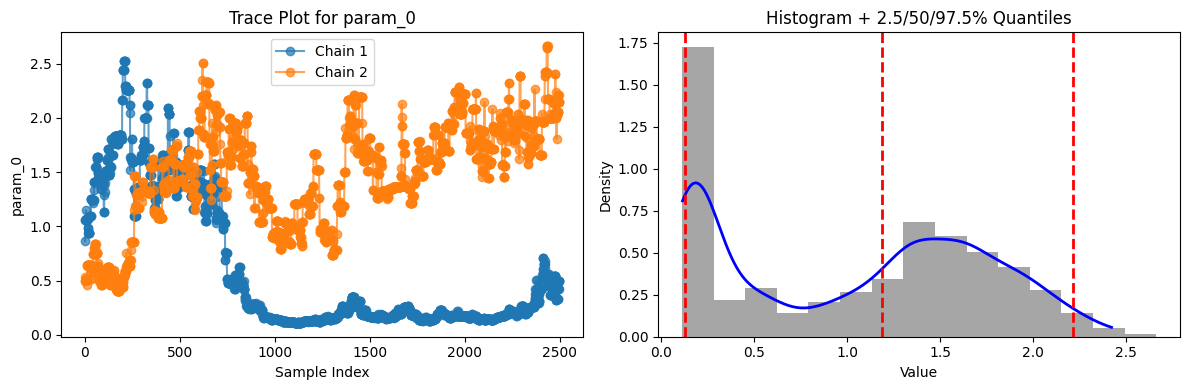

<Figure size 600x400 with 0 Axes>

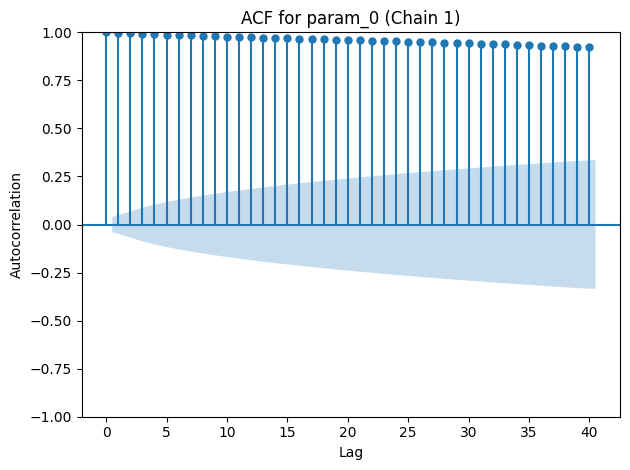

param_1: R-hat = 1.643, split R-hat = 2.062, ESS = 2.1


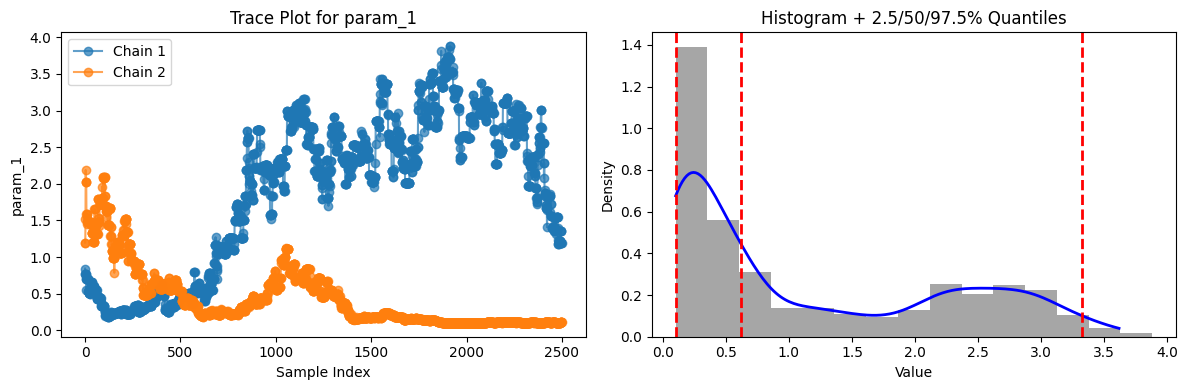

<Figure size 600x400 with 0 Axes>

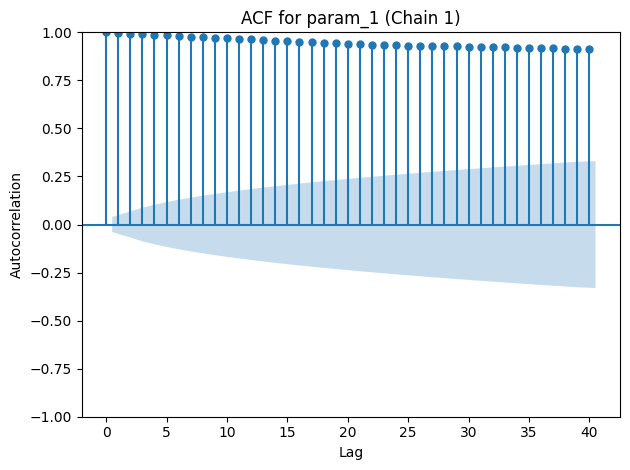

param_2: R-hat = 1.191, split R-hat = 1.275, ESS = 6.3


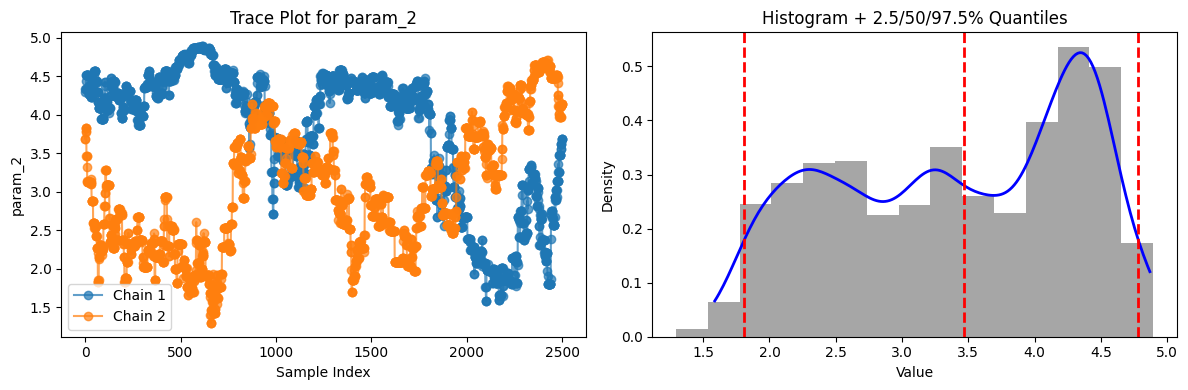

<Figure size 600x400 with 0 Axes>

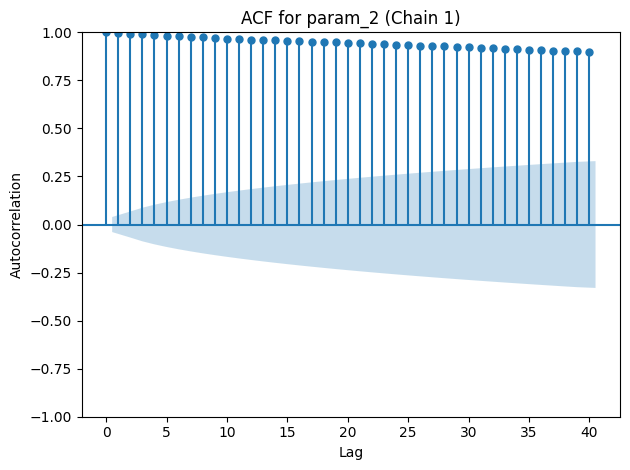

param_3: R-hat = 1.275, split R-hat = 1.386, ESS = 4.4


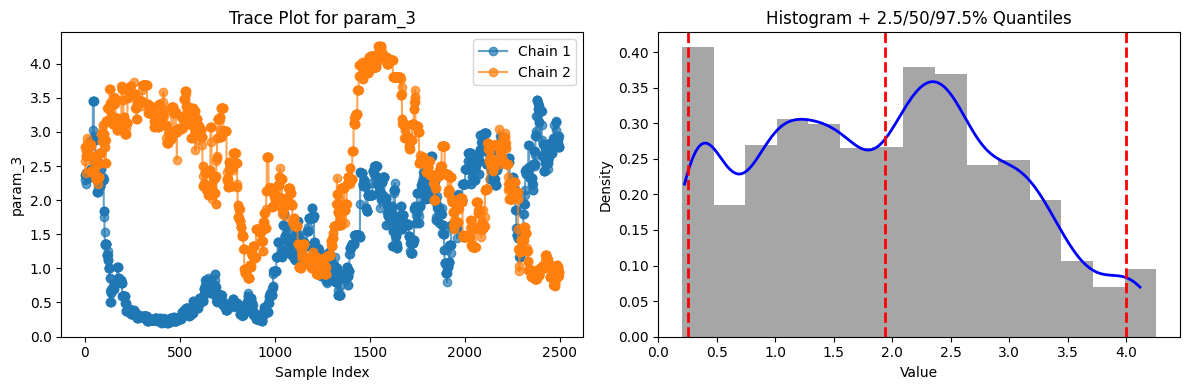

<Figure size 600x400 with 0 Axes>

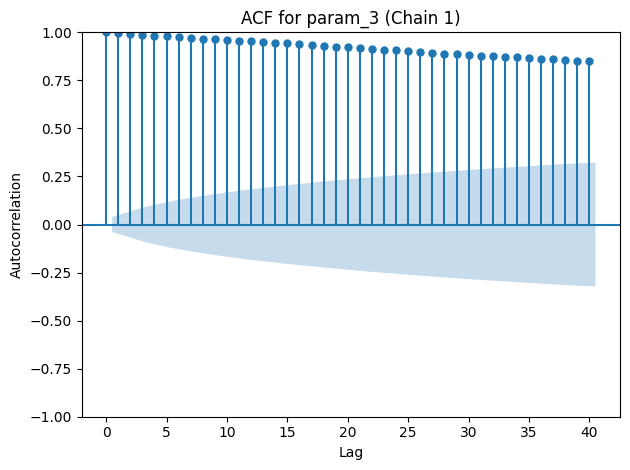

param_4: R-hat = 1.002, split R-hat = 1.091, ESS = 14.4


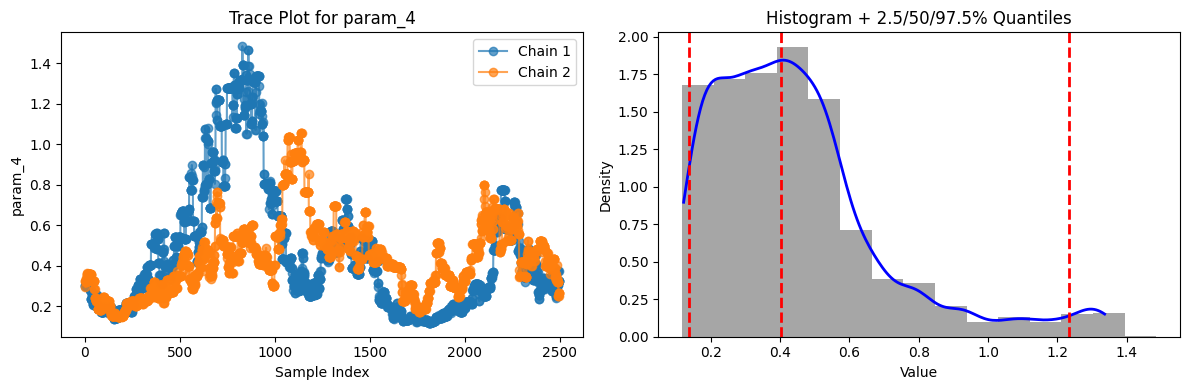

<Figure size 600x400 with 0 Axes>

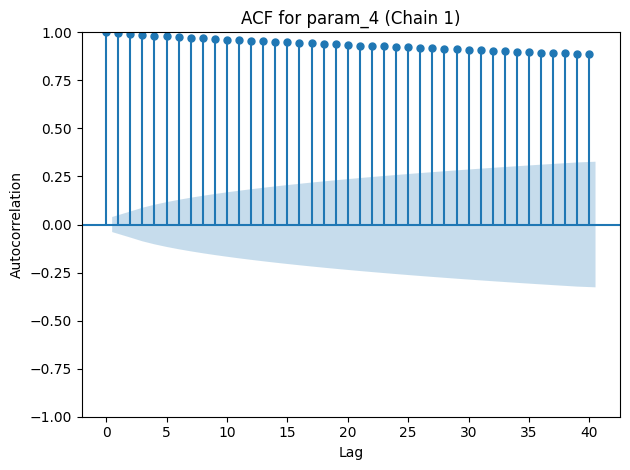

param_5: R-hat = 1.027, split R-hat = 1.127, ESS = 13.5


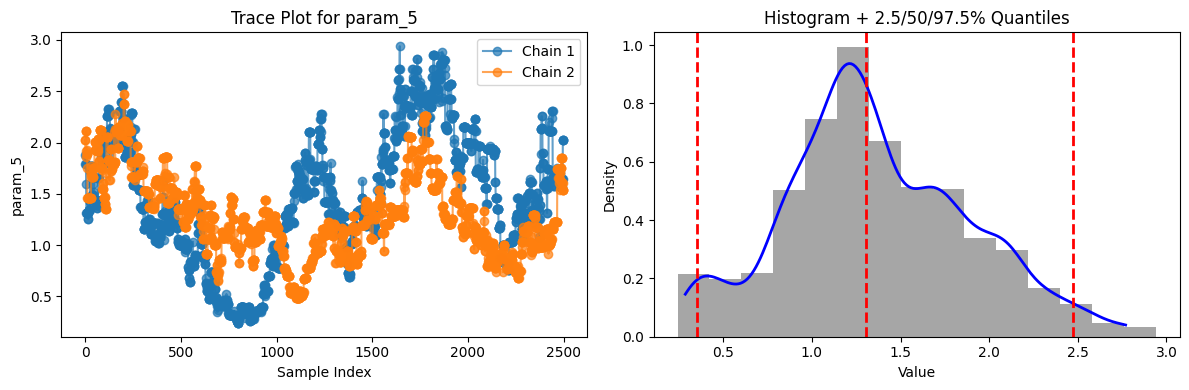

<Figure size 600x400 with 0 Axes>

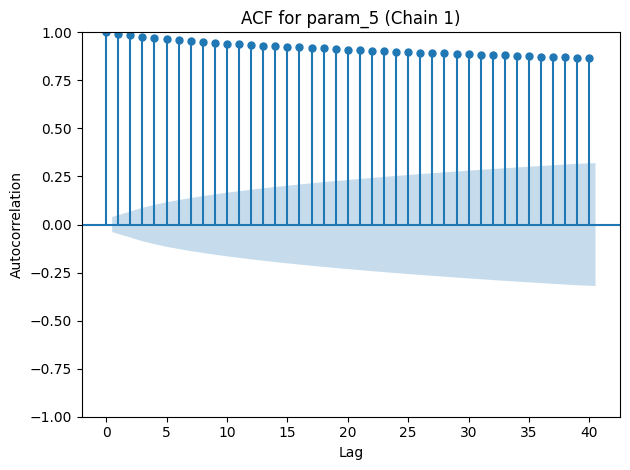

param_6: R-hat = 1.612, split R-hat = 2.630, ESS = 2.2


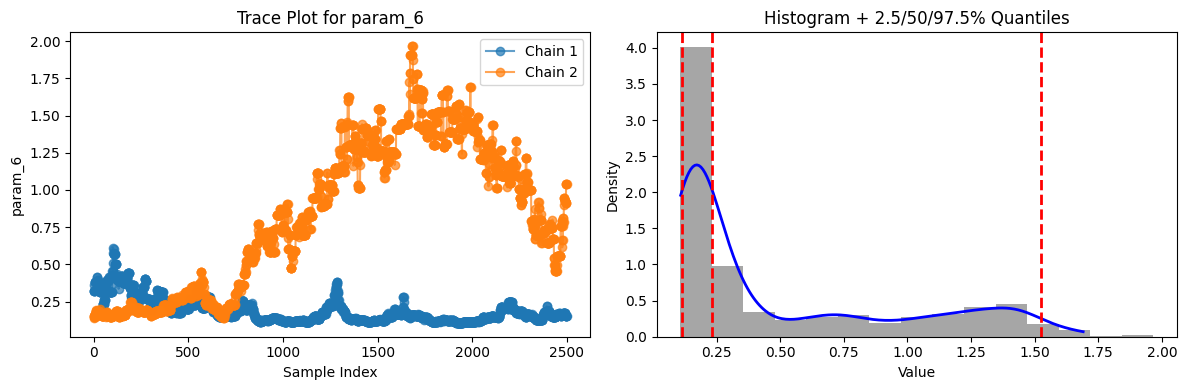

<Figure size 600x400 with 0 Axes>

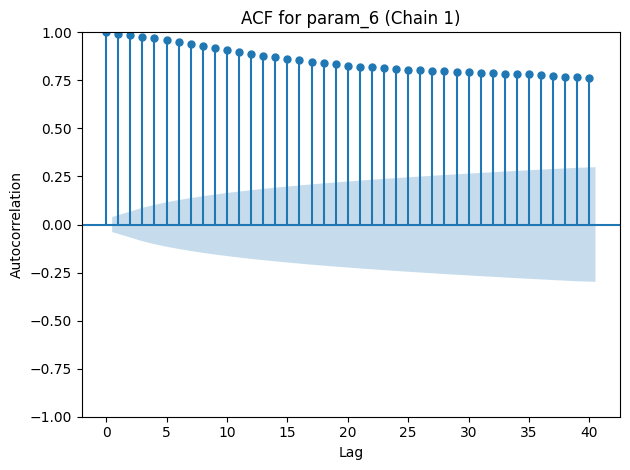

param_7: R-hat = 1.691, split R-hat = 2.357, ESS = 1.9


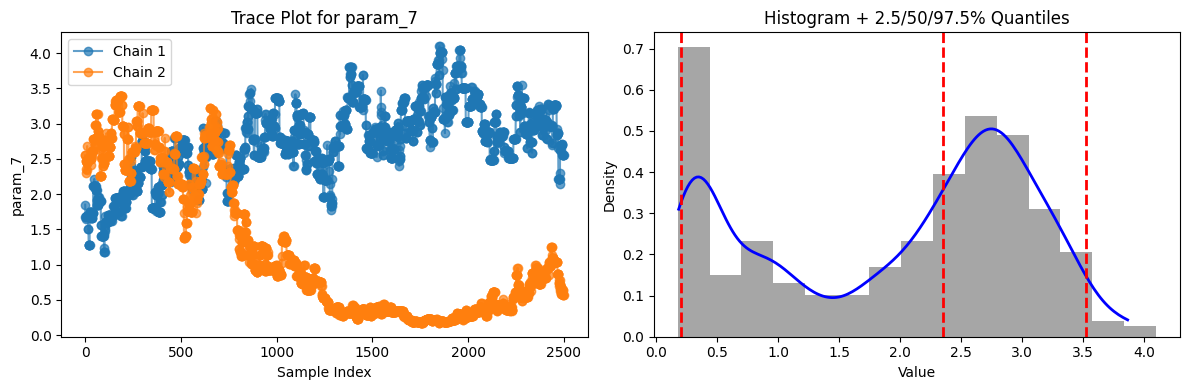

<Figure size 600x400 with 0 Axes>

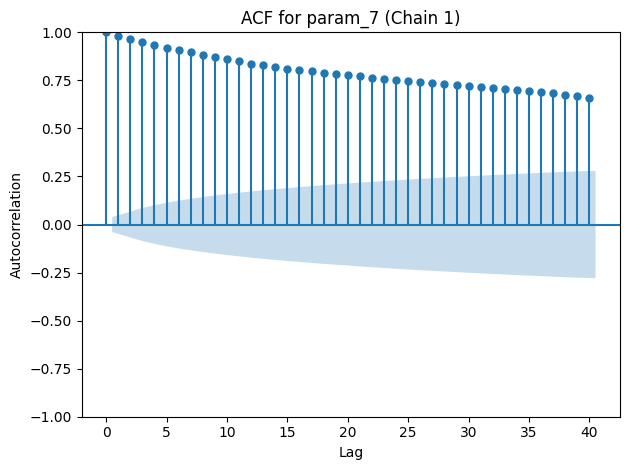

param_8: R-hat = 1.038, split R-hat = 1.241, ESS = 10.9


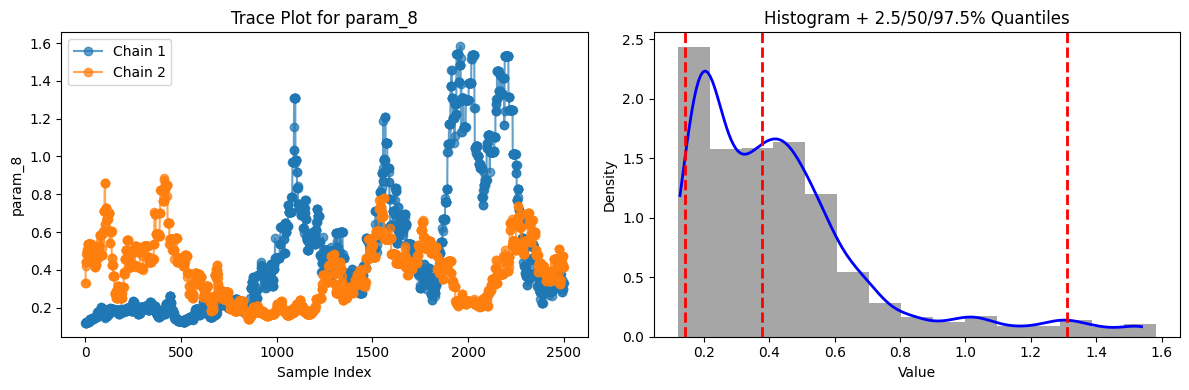

<Figure size 600x400 with 0 Axes>

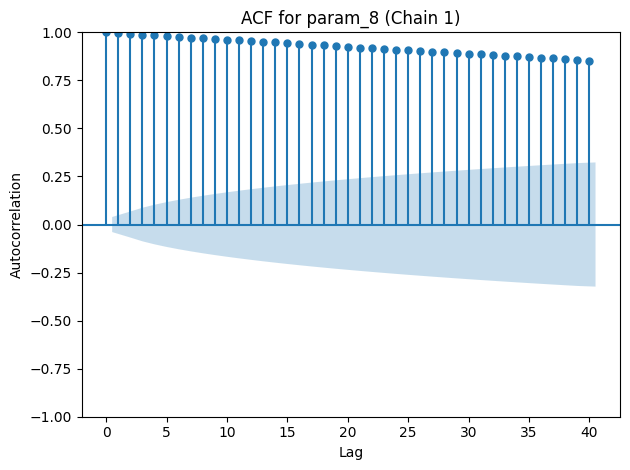

param_9: R-hat = 1.015, split R-hat = 1.247, ESS = 10.3


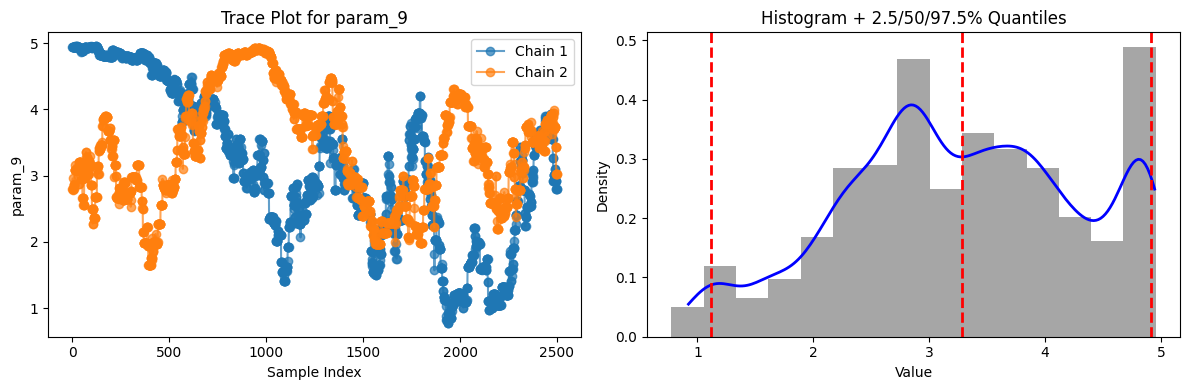

<Figure size 600x400 with 0 Axes>

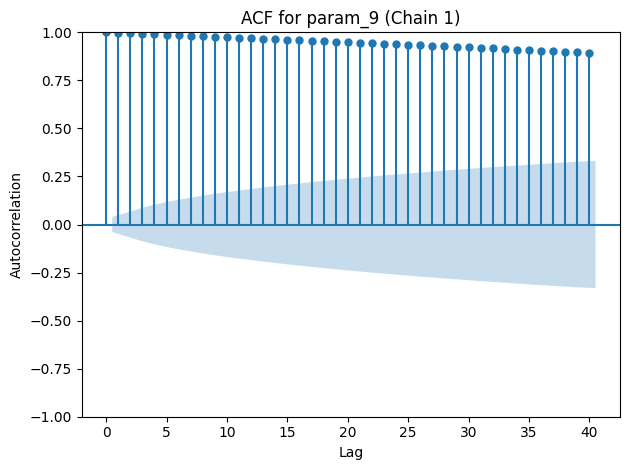

sigma_meas: R-hat = 1.003, split R-hat = 1.009, ESS = 571.2


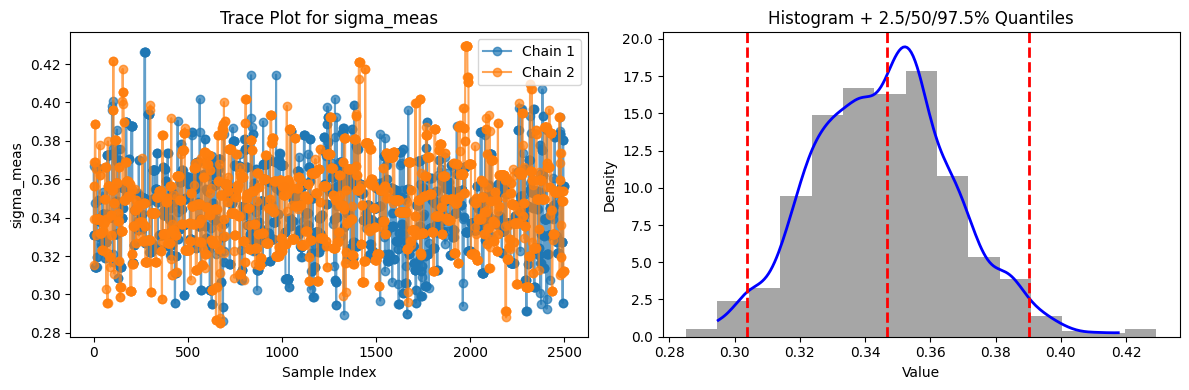

<Figure size 600x400 with 0 Axes>

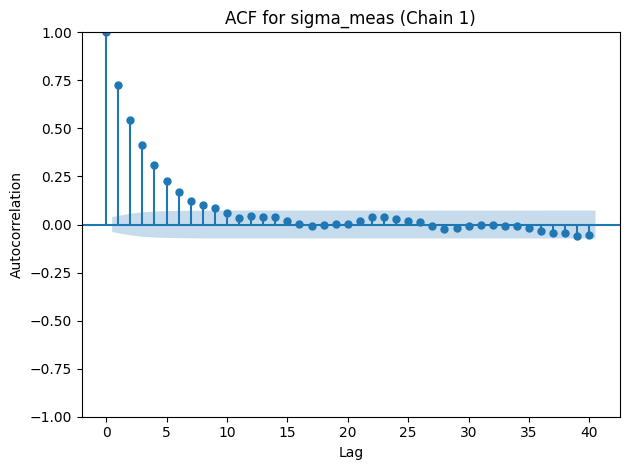

In [14]:

single_chain_samples = samples  # samples or loaded_samples

# 将每条参数的样本拆成两半
def split_chain(chain_tensor):
    n = chain_tensor.shape[0]
    half = n // 2
    return chain_tensor[:half], chain_tensor[half:2*half]

# 整理成 mcmc_samples：param -> Tensor[2, n_half]
mcmc_samples = {}
for param, samples in single_chain_samples.items():
    chain_a, chain_b = split_chain(samples)
    # 如果原链长度是奇数，可以选择丢弃最后一个样本或做其他处理
    mcmc_samples[param] = torch.stack([chain_a, chain_b], dim=0)




# 诊断和可视化
for param, samples_chains in mcmc_samples.items():

    
    # 计算诊断量
    rhat = gelman_rubin(samples_chains, chain_dim=0, sample_dim=1)
    split_rhat = split_gelman_rubin(samples_chains, chain_dim=0, sample_dim=1)
    ess = effective_sample_size(samples_chains, chain_dim=0, sample_dim=1)
    print(f"{param}: R-hat = {rhat:.3f}, split R-hat = {split_rhat:.3f}, ESS = {ess:.1f}")
    
    # 绘制 Trace Plot
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    for i in range(2):
        plt.plot(samples_chains[i].cpu().numpy(), marker='o', label=f"Chain {i+1}", alpha=0.7)

    plt.title(f"Trace Plot for {param}")
    plt.xlabel("Sample Index")
    plt.ylabel(param)
    plt.legend()
    
    # 绘制 Histogram + Quantiles
    plt.subplot(1, 2, 2)
    all_samps = samples_chains.reshape(-1).cpu().numpy()

    xmin, xmax = np.percentile(all_samps, [0.5, 99.5])

    plt.hist(all_samps, bins=15, density=True, alpha=0.7, color='gray')

    kde = gaussian_kde(all_samps)
    x_grid = np.linspace(xmin, xmax, 200)
    # plt.plot(x_grid, kde(x_grid), color='blue', linewidth=2, label="KDE")
    plt.plot(x_grid, kde(x_grid), color='blue', linewidth=2)

    qs = torch.quantile(torch.from_numpy(all_samps), torch.tensor([0.025, 0.5, 0.975]))
    for q in qs:
        plt.axvline(q.item(), color='red', linestyle='--', linewidth=2)
    
    # plt.xlim(0.1, 5)

    plt.title(f"Histogram + 2.5/50/97.5% Quantiles")
    plt.xlabel("Value")
    plt.ylabel("Density")
    plt.tight_layout()
    plt.show()
    
    # 绘制 ACF（仅第一“伪链”）
    plt.figure(figsize=(6,4))
    plot_acf(samples_chains[0].cpu().numpy(), lags=40)
    plt.title(f"ACF for {param} (Chain 1)")
    plt.xlabel("Lag")
    plt.ylabel("Autocorrelation")
    plt.tight_layout()
    plt.show()

# MCMC 2 chains check

param_0: R-hat = 1.065, split R-hat = 1.045, ESS = 12.5


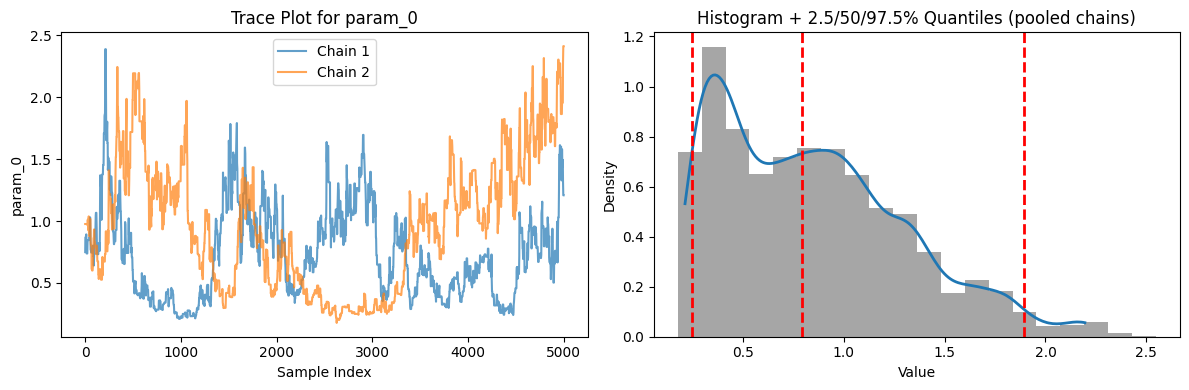

<Figure size 600x400 with 0 Axes>

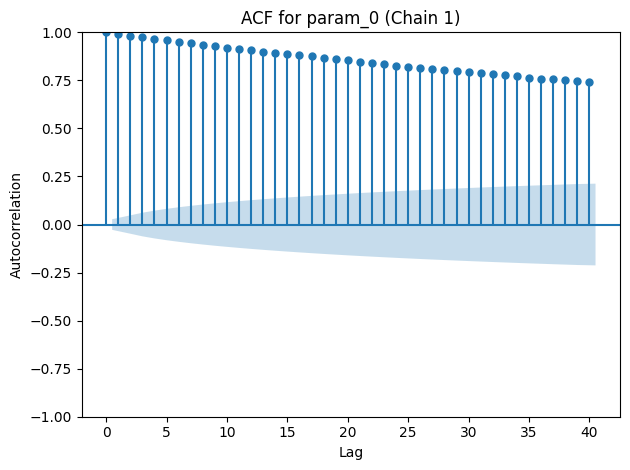

<Figure size 600x400 with 0 Axes>

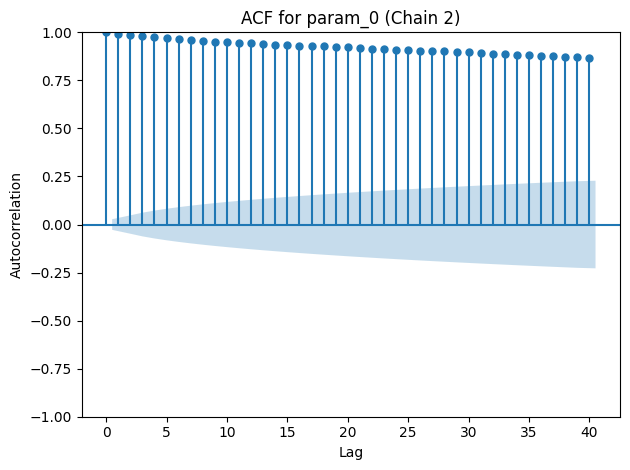

param_1: R-hat = 1.069, split R-hat = 1.051, ESS = 13.2


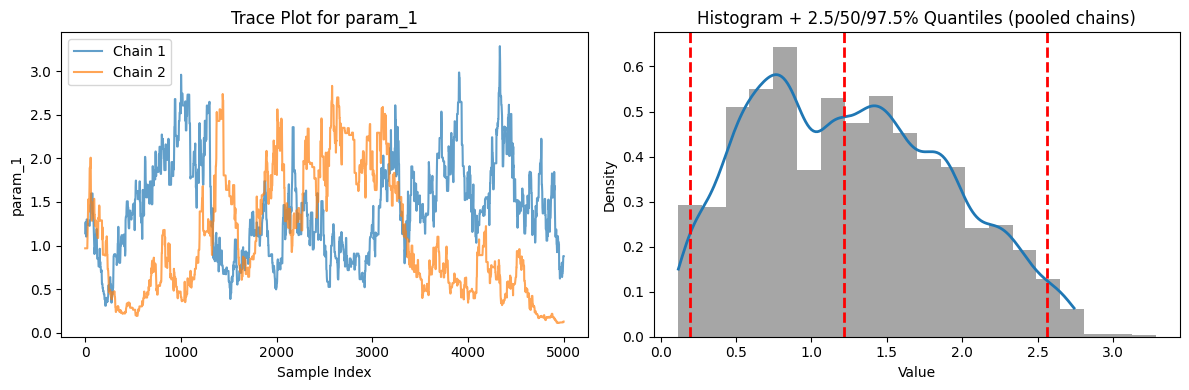

<Figure size 600x400 with 0 Axes>

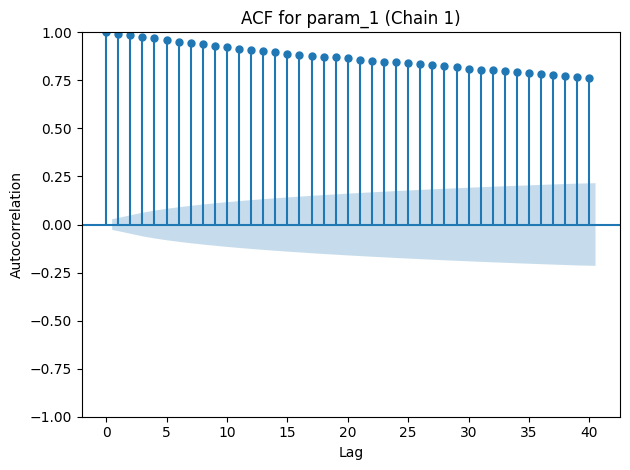

<Figure size 600x400 with 0 Axes>

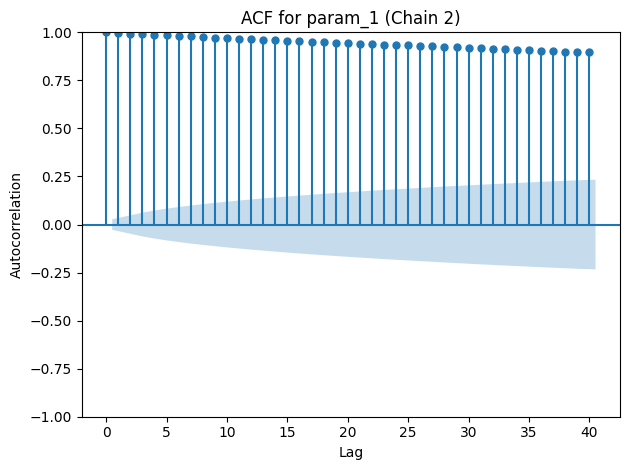

param_2: R-hat = 1.904, split R-hat = 1.873, ESS = 1.6


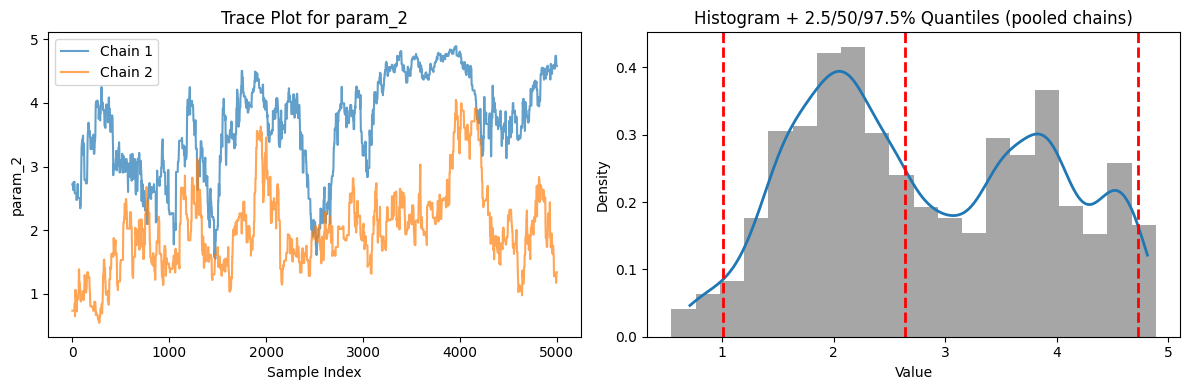

<Figure size 600x400 with 0 Axes>

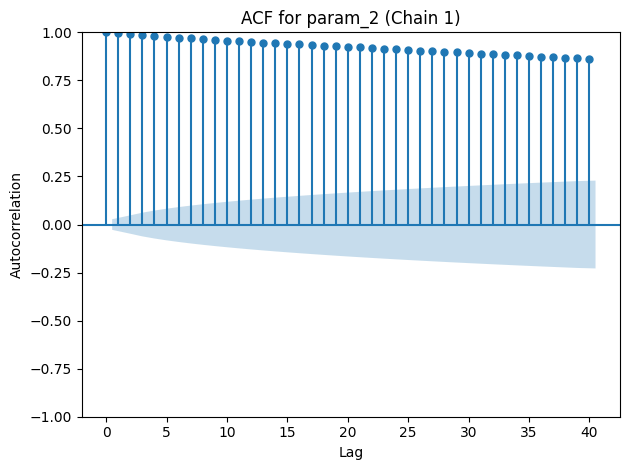

<Figure size 600x400 with 0 Axes>

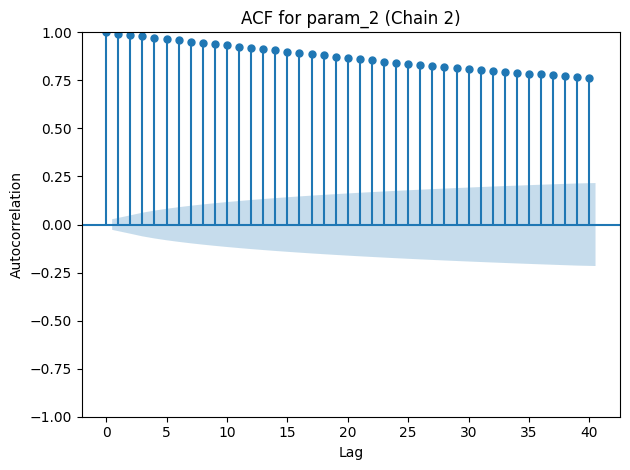

param_3: R-hat = 1.718, split R-hat = 1.757, ESS = 1.7


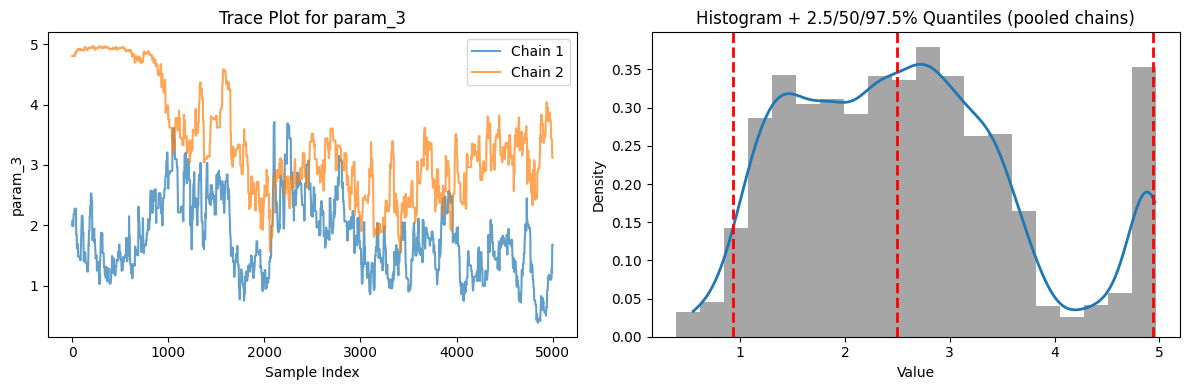

<Figure size 600x400 with 0 Axes>

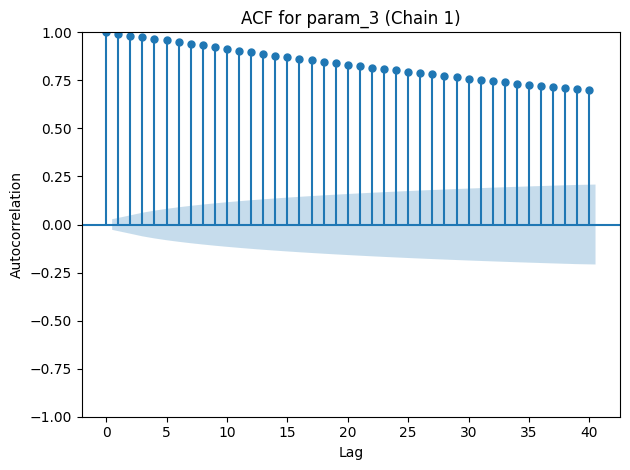

<Figure size 600x400 with 0 Axes>

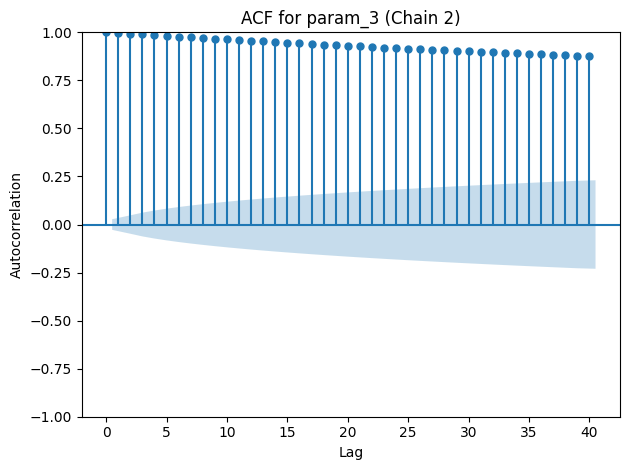

param_4: R-hat = 1.132, split R-hat = 1.189, ESS = 12.7


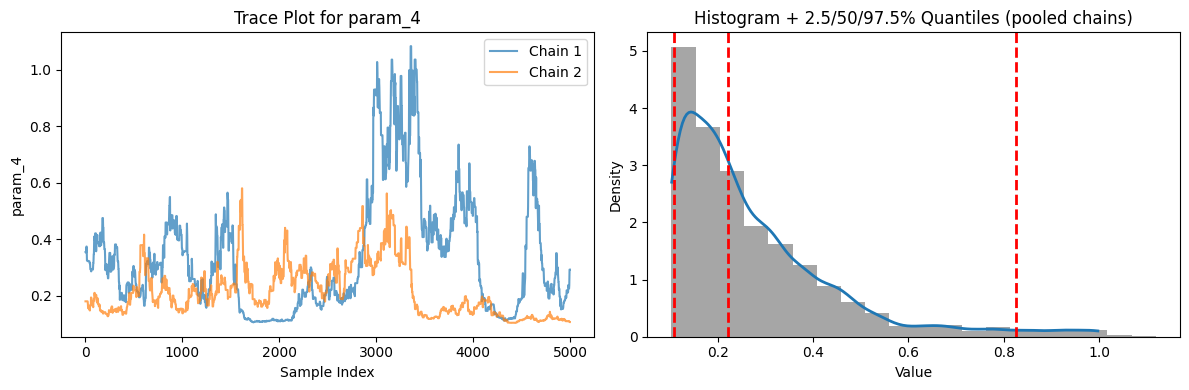

<Figure size 600x400 with 0 Axes>

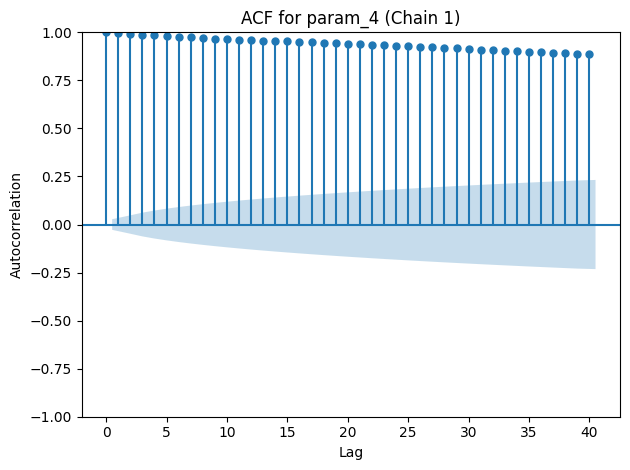

<Figure size 600x400 with 0 Axes>

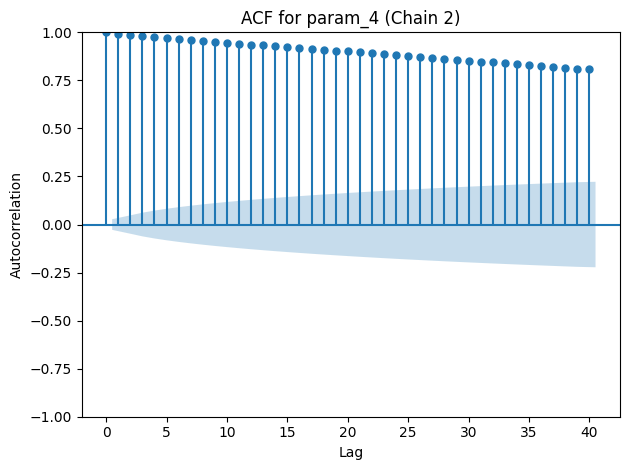

param_5: R-hat = 1.121, split R-hat = 1.156, ESS = 13.2


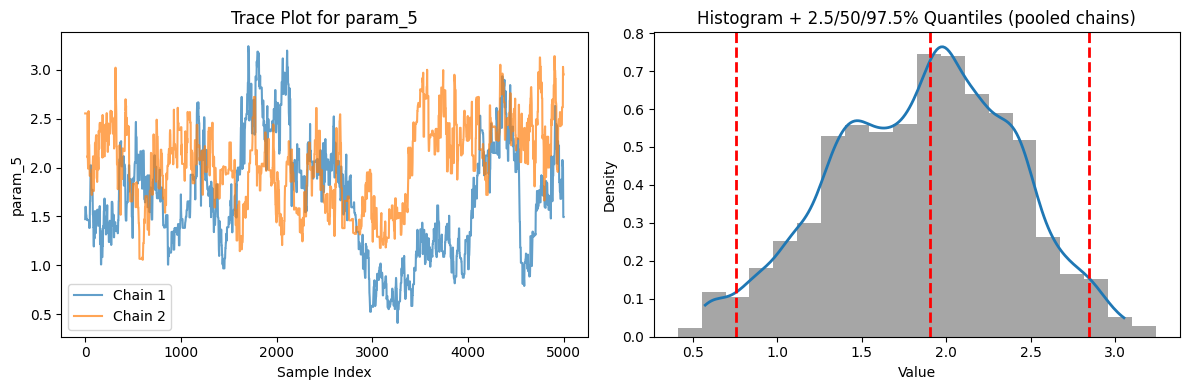

<Figure size 600x400 with 0 Axes>

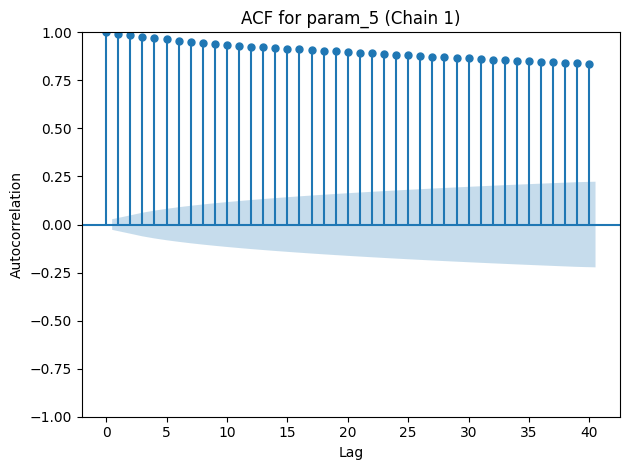

<Figure size 600x400 with 0 Axes>

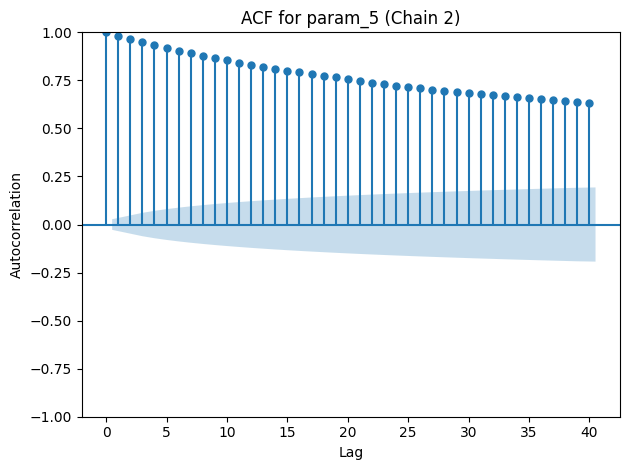

param_6: R-hat = 1.208, split R-hat = 1.536, ESS = 6.4


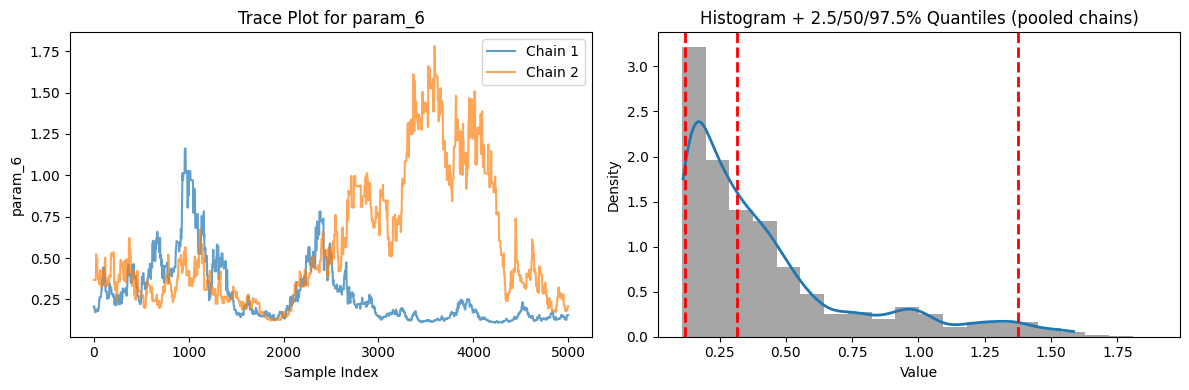

<Figure size 600x400 with 0 Axes>

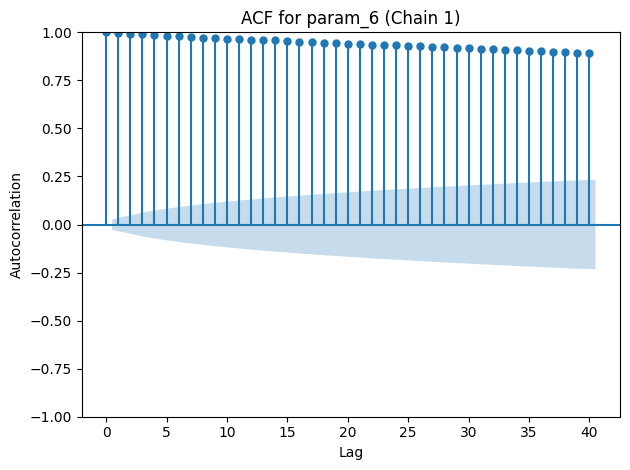

<Figure size 600x400 with 0 Axes>

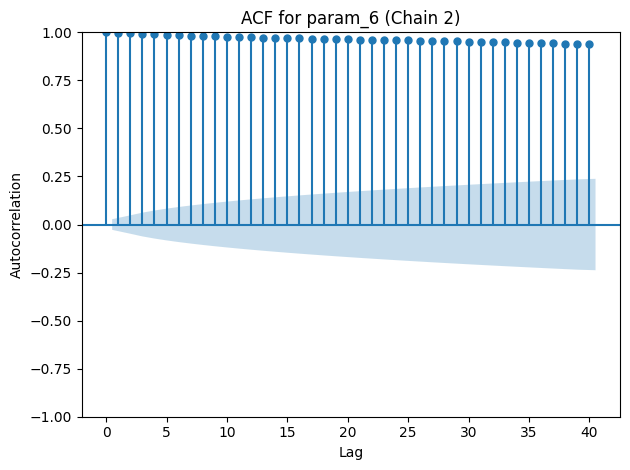

param_7: R-hat = 1.223, split R-hat = 1.574, ESS = 5.7


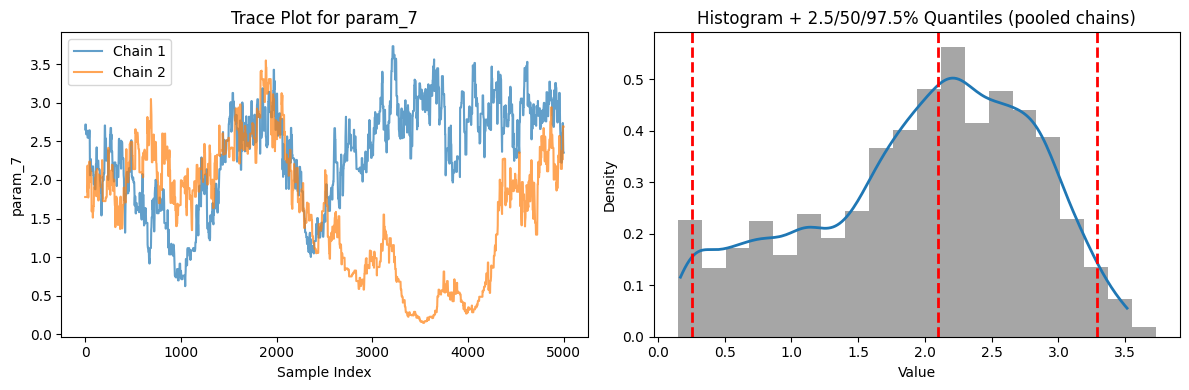

<Figure size 600x400 with 0 Axes>

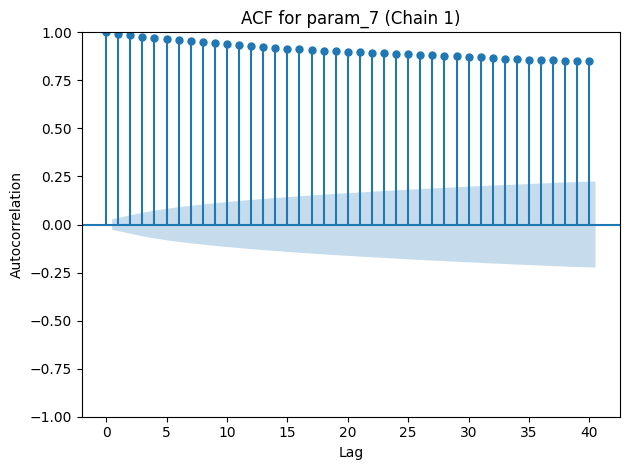

<Figure size 600x400 with 0 Axes>

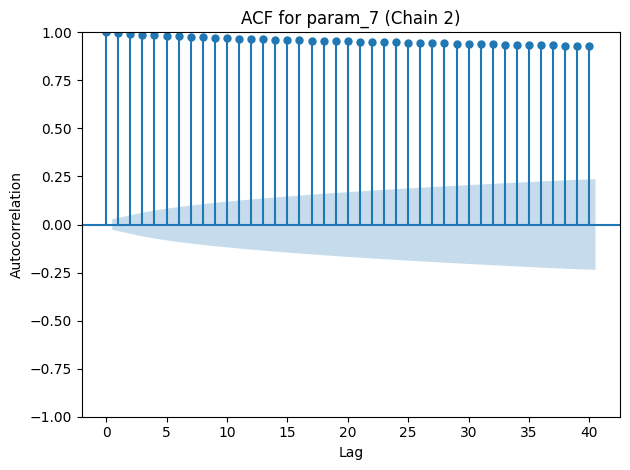

param_8: R-hat = 1.001, split R-hat = 1.045, ESS = 18.6


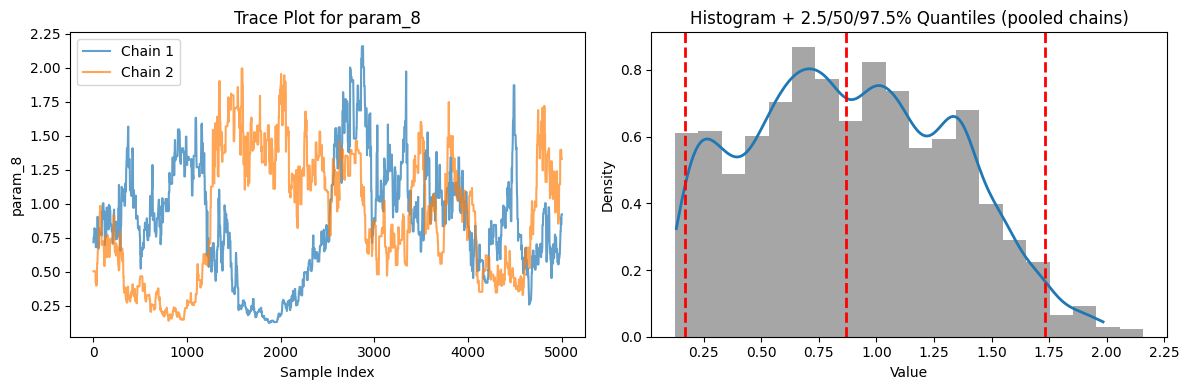

<Figure size 600x400 with 0 Axes>

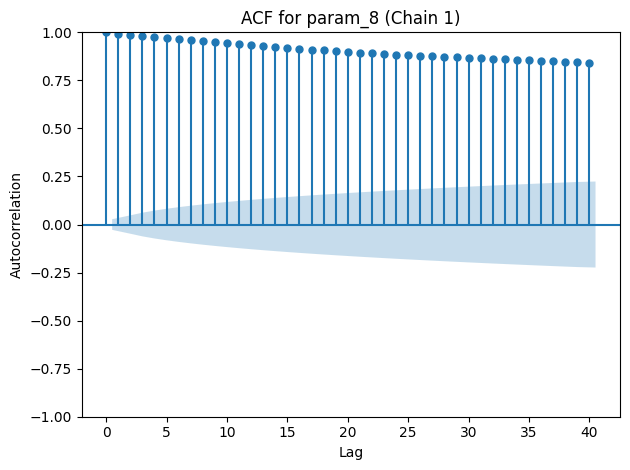

<Figure size 600x400 with 0 Axes>

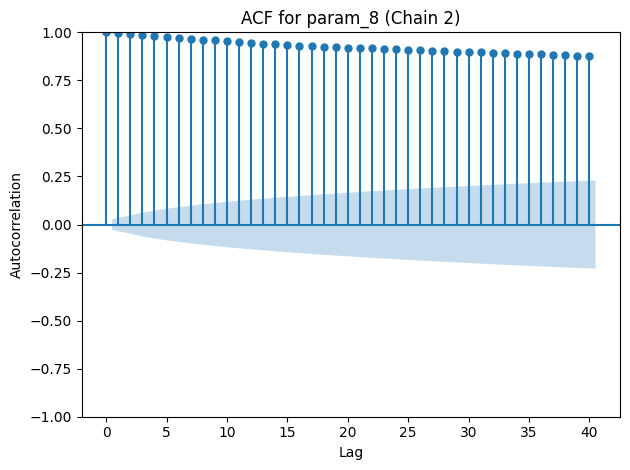

param_9: R-hat = 1.004, split R-hat = 1.061, ESS = 16.2


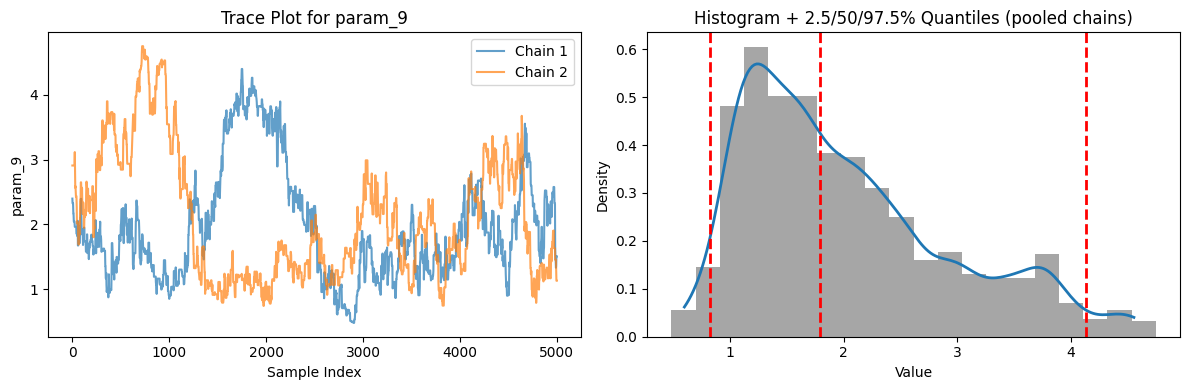

<Figure size 600x400 with 0 Axes>

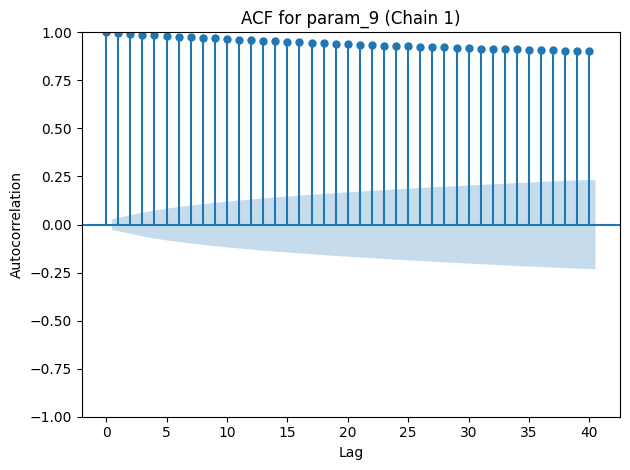

<Figure size 600x400 with 0 Axes>

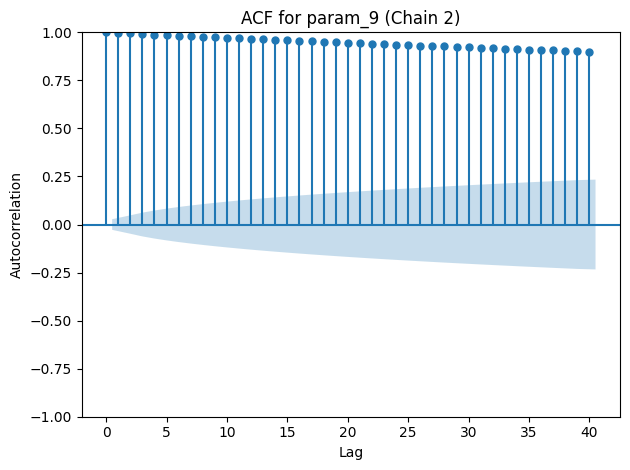

sigma_meas: R-hat = 1.002, split R-hat = 1.002, ESS = 1064.6


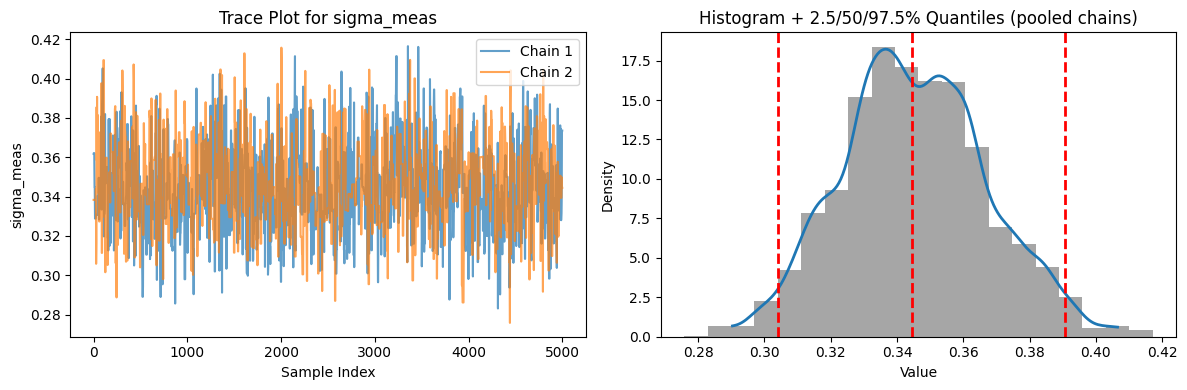

<Figure size 600x400 with 0 Axes>

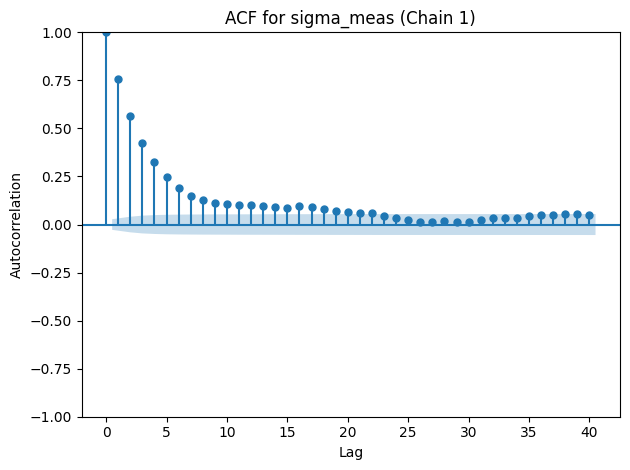

<Figure size 600x400 with 0 Axes>

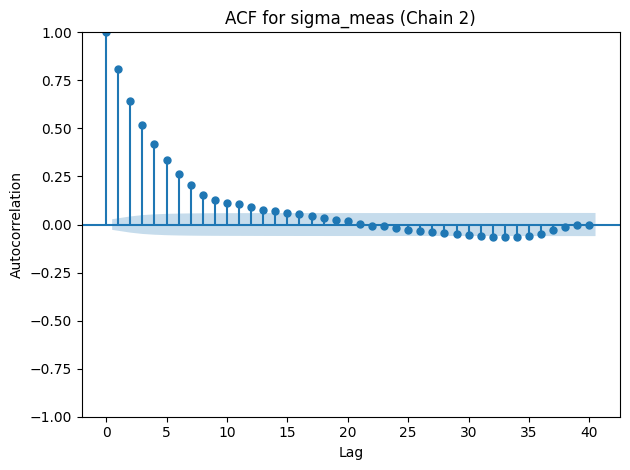

In [22]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from statsmodels.graphics.tsaplots import plot_acf

# 你已有的诊断函数（保持不变）
# from pyro.ops.stats import gelman_rubin, split_gelman_rubin, effective_sample_size

def stack_chains(chain_dicts, truncate_to_min=True):
    """
    chain_dicts: List[Dict[param, Tensor]]
        每个 dict 是一条链的 samples：param -> Tensor[S] 或 Tensor[S,D] ...
    返回: Dict[param, Tensor[C,S,...]]
    """
    if not isinstance(chain_dicts, (list, tuple)) or len(chain_dicts) < 2:
        raise ValueError("chain_dicts 应该是包含>=2条链的 list/tuple，每条链是一个 samples dict。")

    # 参数名交集（避免某条链缺参数）
    common_params = set(chain_dicts[0].keys())
    for d in chain_dicts[1:]:
        common_params &= set(d.keys())
    if len(common_params) == 0:
        raise ValueError("多条链之间没有共同的参数键名，无法对齐 stack。")

    out = {}
    for p in sorted(common_params):
        xs = [d[p].detach() for d in chain_dicts]

        # 统一为 torch.Tensor
        xs = [x if torch.is_tensor(x) else torch.as_tensor(x) for x in xs]

        # 统一 sample 维在 dim=0（假定每条链是 [S,...]）
        # 如果你某条链的参数是标量（dim=0），强制扩成 [S=1]
        xs = [x.unsqueeze(0) if x.dim() == 0 else x for x in xs]

        # 长度处理
        lens = [x.shape[0] for x in xs]
        if truncate_to_min:
            L = min(lens)
            xs = [x[:L] for x in xs]
        else:
            # 不截断则要求长度一致
            if len(set(lens)) != 1:
                raise ValueError(f"参数 {p} 各链长度不一致: {lens}。可设置 truncate_to_min=True。")

        out[p] = torch.stack(xs, dim=0)  # [C,S,...]
    return out

def scalarize_stat(x):
    """把诊断量转成可打印标量：标量直接 item，多元素取 mean。"""
    if isinstance(x, (float, int)):
        return float(x)
    if torch.is_tensor(x):
        return x.item() if x.numel() == 1 else x.mean().item()
    return float(x)

# -----------------------
# 你的输入：多条链分别的 samples
# 例如：
# chain_dicts = [samples_chain0, samples_chain1, samples_chain2, ...]
# -----------------------
chain_dicts = [samples_1, samples_2]  # <- 你把自己的多链 list 变量名放这里

mcmc_samples = stack_chains(chain_dicts, truncate_to_min=True)  # param -> [C,S,...]

# -----------------------
# 诊断与可视化（多链，不拆链）
# -----------------------
max_trace_points = 2000
acf_lags = 40

for param, samples_chains in mcmc_samples.items():
    # samples_chains: [C, S, ...]
    C, S = samples_chains.shape[0], samples_chains.shape[1]

    # 如果参数是向量/矩阵：例如 [C,S,D]，这里默认取第0个分量画图
    # 你也可以改成循环 d=0..D-1 逐个画
    if samples_chains.dim() > 2:
        samples_to_plot = samples_chains[..., 0]   # [C,S]
        plot_label = f"{param}[0]"
    else:
        samples_to_plot = samples_chains           # [C,S]
        plot_label = str(param)

    # 诊断量（chain_dim=0, sample_dim=1）
    rhat = gelman_rubin(samples_to_plot, chain_dim=0, sample_dim=1)
    split_rhat = split_gelman_rubin(samples_to_plot, chain_dim=0, sample_dim=1)
    ess = effective_sample_size(samples_to_plot, chain_dim=0, sample_dim=1)

    print(
        f"{plot_label}: R-hat = {scalarize_stat(rhat):.3f}, "
        f"split R-hat = {scalarize_stat(split_rhat):.3f}, "
        f"ESS = {scalarize_stat(ess):.1f}"
    )

    # Trace + Histogram
    plt.figure(figsize=(12, 4))

    # Trace plot
    plt.subplot(1, 2, 1)
    if S > max_trace_points:
        idx = torch.linspace(0, S - 1, steps=max_trace_points).long()
        x_axis = idx.cpu().numpy()
    else:
        idx = None
        x_axis = np.arange(S)

    for i in range(C):
        y = samples_to_plot[i]
        if idx is not None:
            y = y[idx]
        plt.plot(x_axis, y.cpu().numpy(), label=f"Chain {i+1}", alpha=0.7)

    plt.title(f"Trace Plot for {plot_label}")
    plt.xlabel("Sample Index")
    plt.ylabel(plot_label)
    plt.legend()

    # Histogram + KDE + Quantiles（合并所有链）
    plt.subplot(1, 2, 2)
    pooled_t = samples_to_plot.reshape(-1).cpu()
    pooled = pooled_t.numpy()

    xmin, xmax = np.percentile(pooled, [0.5, 99.5])
    plt.hist(pooled, bins=20, density=True, alpha=0.7, color="gray")

    if len(pooled) > 5:
        kde = gaussian_kde(pooled)
        x_grid = np.linspace(xmin, xmax, 200)
        plt.plot(x_grid, kde(x_grid), linewidth=2)

    qs = torch.quantile(pooled_t, torch.tensor([0.025, 0.5, 0.975]))
    for q in qs:
        plt.axvline(q.item(), color="red", linestyle="--", linewidth=2)

    plt.title("Histogram + 2.5/50/97.5% Quantiles (pooled chains)")
    plt.xlabel("Value")
    plt.ylabel("Density")

    plt.tight_layout()
    plt.show()

    # ACF：每条链一张
    for i in range(C):
        plt.figure(figsize=(6, 4))
        plot_acf(samples_to_plot[i].cpu().numpy(), lags=acf_lags)
        plt.title(f"ACF for {plot_label} (Chain {i+1})")
        plt.xlabel("Lag")
        plt.ylabel("Autocorrelation")
        plt.tight_layout()
        plt.show()


In [30]:
def posterior_grid_10pts(samples: dict, q_low=0.025, q_high=0.975, n=10):

    grids = {}

    for name, s in samples.items():

        s = s.to(dtype=torch.float32)
        s_flat = s.reshape(-1, *s.shape[1:])  # (S_total, ...)

        qs = torch.tensor([q_low, q_high], device=s_flat.device, dtype=s_flat.dtype)
        q_vals = torch.quantile(s_flat, qs, dim=0)  # shape (2, ...)

        lo = q_vals[0]
        hi = q_vals[1]

        grid = torch.linspace(0.0, 1.0, steps=n, device=s_flat.device, dtype=s_flat.dtype)
        grid = lo + (hi - lo) * grid.view(n, *([1] * lo.dim()))  # (n, ...) broadcast

        grids[name] = grid

    return grids




In [ ]:
samples = mcmc.get_samples()

In [31]:
posterior_grid_10pts(loaded_samples, q_low=0.025, q_high=0.975, n=2)


{'param_0': tensor([0.1008, 0.1308], device='cuda:0'),
 'param_1': tensor([3.0812, 3.9006], device='cuda:0'),
 'param_2': tensor([1.2060, 2.1293], device='cuda:0'),
 'param_3': tensor([4.7699, 4.9988], device='cuda:0'),
 'param_4': tensor([0.1004, 0.1255], device='cuda:0'),
 'param_5': tensor([2.2771, 2.5231], device='cuda:0'),
 'param_6': tensor([0.1008, 0.1488], device='cuda:0'),
 'param_7': tensor([2.6831, 3.0625], device='cuda:0'),
 'param_8': tensor([0.1006, 0.1369], device='cuda:0'),
 'param_9': tensor([4.9336, 4.9987], device='cuda:0')}

In [ ]:
grids

In [ ]:
test_r = [(0.1007), 
          (4.9434), 
          (4.9593), 
          (0.1004), 
          (0.1003), 
          (2.2825),
          (1.3757), 
          (0.1009), 
          (2.2874), 
          (0.1001)]

Prediction.preds_for_one_model(MVGP_models, MVGP_likelihoods, torch.tensor(test_r).cuda().unsqueeze(0)).cpu().detach().numpy()

In [ ]:
realcase_y

# Plot

In [3]:
Y_RC_PE = pd.read_csv('RealCase/simulation_results_RC.txt', header=None, delimiter=' ')
Y_RC_PE = Y_RC_PE.drop(columns=[Y_RC_PE.columns[-1]])

df_new = Y_RC_PE.drop(Y_RC_PE.columns[-18:], axis=1)
Y_RC_PE = df_new.drop(df_new.columns[17], axis=1)

Y_RC_mcmc = pd.read_csv('RealCase/simulation_results_RC_B.txt', header=None, delimiter=' ')
Y_RC_mcmc = Y_RC_mcmc.drop(columns=[Y_RC_mcmc.columns[-1]])

df_new = Y_RC_mcmc.drop(Y_RC_mcmc.columns[-18:], axis=1)
Y_RC_mcmc = df_new.drop(df_new.columns[17], axis=1)

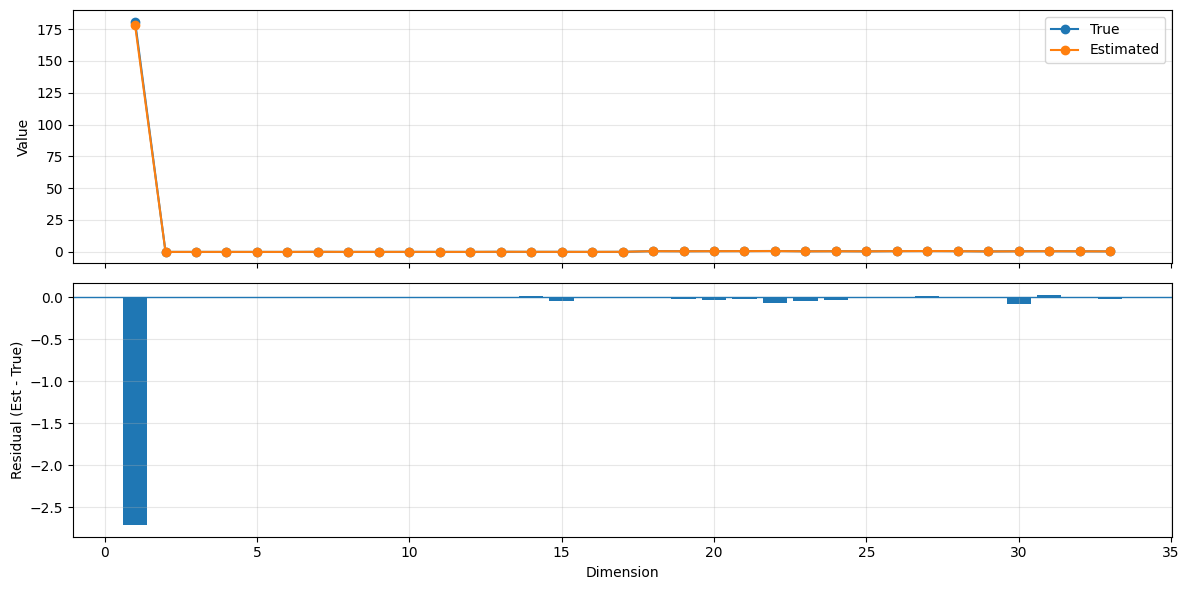

In [11]:
row_idx = 5

y_true = np.asarray(Realcase_data[row_idx]).ravel()
y_hat  = np.asarray(Y_RC_PE).ravel()
e = y_hat - y_true
dims = np.arange(1, len(y_true) + 1)

fig, axes = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

# 上：真值 vs 估计
axes[0].plot(dims, y_true, marker='o', label='True')
axes[0].plot(dims, y_hat,  marker='o', label='Estimated')
axes[0].set_ylabel('Value')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 下：残差
axes[1].bar(dims, e)
axes[1].axhline(0, linewidth=1)
axes[1].set_xlabel('Dimension')
axes[1].set_ylabel('Residual (Est - True)')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


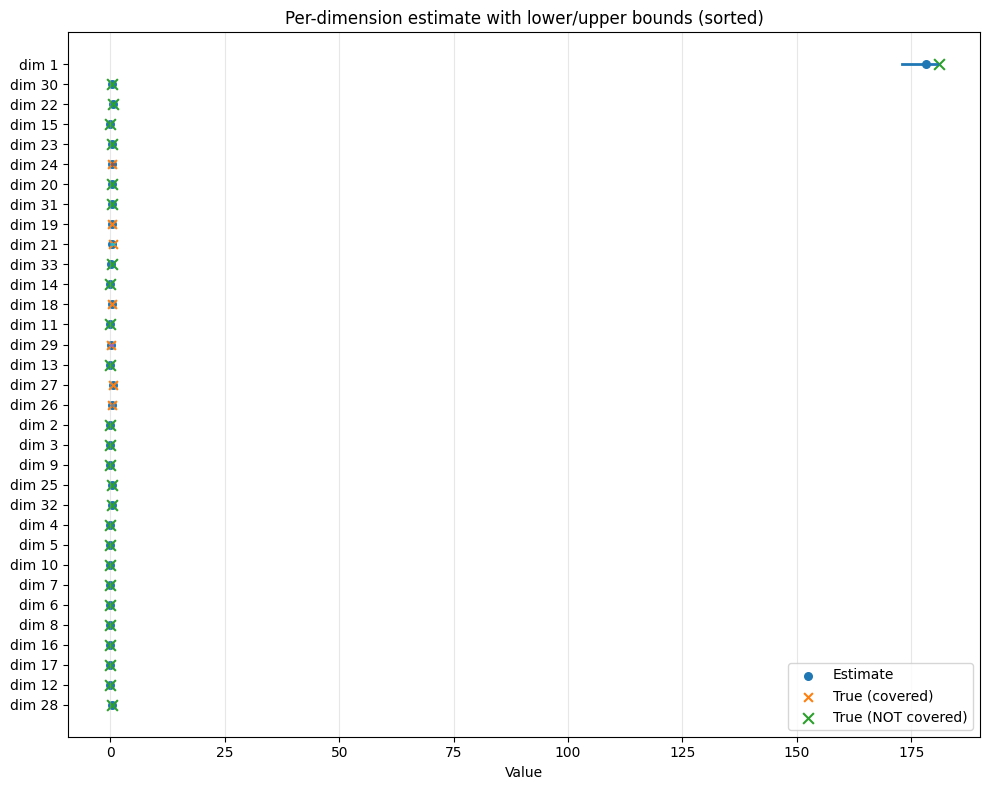

In [16]:
y_true = np.asarray(y_true).ravel()
y_hat  = np.asarray(y_hat).ravel()
y_lo   = np.asarray(Y_RC_mcmc)[1,:].ravel()
y_hi   = np.asarray(Y_RC_mcmc)[0,:].ravel()

D = len(y_true)
assert all(len(x) == D for x in [y_hat, y_lo, y_hi])


covered = (y_true >= y_lo) & (y_true <= y_hi)


abs_err = np.abs(y_hat - y_true)
width   = y_hi - y_lo

order = np.argsort(abs_err)[::-1]   # 误差从大到小
# order = np.argsort(width)[::-1]   # 区间从宽到窄

yt  = y_true[order]
yh  = y_hat[order]
lo  = y_lo[order]
hi  = y_hi[order]
cov = covered[order]

ypos = np.arange(D)

fig, ax = plt.subplots(figsize=(10, 8))

# 区间线段
for i in range(D):
    ax.plot([lo[i], hi[i]], [ypos[i], ypos[i]], linewidth=2)

# 点估计
ax.scatter(yh, ypos, s=30, label='Estimate')

# 真值：用不同 marker；未覆盖的点单独高亮
ax.scatter(yt[cov], ypos[cov], marker='x', s=40, label='True (covered)')
ax.scatter(yt[~cov], ypos[~cov], marker='x', s=60, label='True (NOT covered)')

ax.set_yticks(ypos)
ax.set_yticklabels([f"dim {k+1}" for k in order])  # 若有维度名，可替换这里
ax.invert_yaxis()  # 让最“差”的维度在顶部（因为我们按误差降序）
ax.set_xlabel('Value')
ax.set_title('Per-dimension estimate with lower/upper bounds (sorted)')
ax.grid(True, axis='x', alpha=0.3)
ax.legend()
plt.tight_layout()
plt.show()


# End